## Test fonction run exp

### 1. Imports

In [1]:

import torch
import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import stat_reliability_measure.dev.torch_utils as t_u
import stat_reliability_measure.dev.torch_utils2 as t_u2
from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from stat_reliability_measure.config import ExpModelConfig
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_pyt2 as smc_pyt2

import stat_reliability_measure.dev.smc.smc_config as smc_config
import stat_reliability_measure.dev.smc.smc_config2 as smc_config2

import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.imp_sampling.is_pyt as is_pyt
import stat_reliability_measure.dev.imp_sampling.is_config as is_config
import stat_reliability_measure.dev.torch_arch as t_a
from stat_reliability_measure.dev.utils import range_vars,simple_vars
import pandas as pd
import numpy as np
import os 


### 2. Model & Data load

In [3]:
reload(config_)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = t_a.dnn2()
model.load_state_dict(torch.load('../models/mnist/model_dnn2_release.pt'))
model.to(device)
model.eval()

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

In [5]:
config = ExpModelConfig( model=model)

In [6]:
config.update()
os.rmdir(config.exp_log_path)

In [7]:
X,y = config.X[:1], config.y[:1]

In [8]:
config.sample_accuracy

0.9921875

## 3. Experiments with MALA-SMC, ours implementation and Webb's implementation of AMLS algorithm

In [11]:
epsilon_range=[0.18]
dataset='mnist'
n_rep = 100 
method_ref='mala2'
method_ref_name='MALA_SMC'
N_ref = 4000
T_ref = 200
ess_ref = 0.8
alpha_ref = 0.2
n_rep_ref = 400

In [12]:
X.requires_grad = True

In [13]:
x_0 = X[0]

In [14]:
p_ref, dict_out = run_exp.run_est(model=model,X=X,y=y, 
                                                repeat_exp=False, track_dt=False,
                                             method='mala2', dataset_name=dataset,
                                             n_rep=n_rep_ref,
                                epsilon_range=epsilon_range, update_aggr_res=True ,
                                track_accept=False,
                                N_range=[N_ref], T_range =[T_ref],ess_alpha = ess_ref,
                                alpha=alpha_ref)

with parameters in {'N_range': [4000], 'T_range': [200], 'ess_alpha_range': [0.8], 'alpha_range': [0.2], 'L_range': [1]}
Experiment already done for method: MALA_SMC
Skipping MALA_SMC run 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 4000: T: 200: ess_alpha: 0.8: alpha: 0.2: L: 1


In [15]:
agg_res_df = pd.read_csv('../logs/exp_model_mnist/aggr_res.csv')
# ref_exp = utils.get_sel_df(df=agg_res_df, triplets=[('method_name',method_ref,'='),('n_rep',n_rep_ref,'='),
#                                                     ('epsilon',epsilon_range[0],'='),
#         ('N',N_ref,'='),('T',T_ref,'='),('alpha',alpha_ref,'='), ])
# p_ref,std_ref =ref_exp['mean_est'].values[0], ref_exp['std_est'].values[0]
# p_ref,std_ref

/tmp/ipykernel_4606/2413165160.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_data['mean_log10_est'] = ref_data['mean_log_est']/np.log(10)
/tmp/ipykernel_4606/2413165160.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_data['std_log10_est'] = ref_data['std_log_est']/np.log(10)


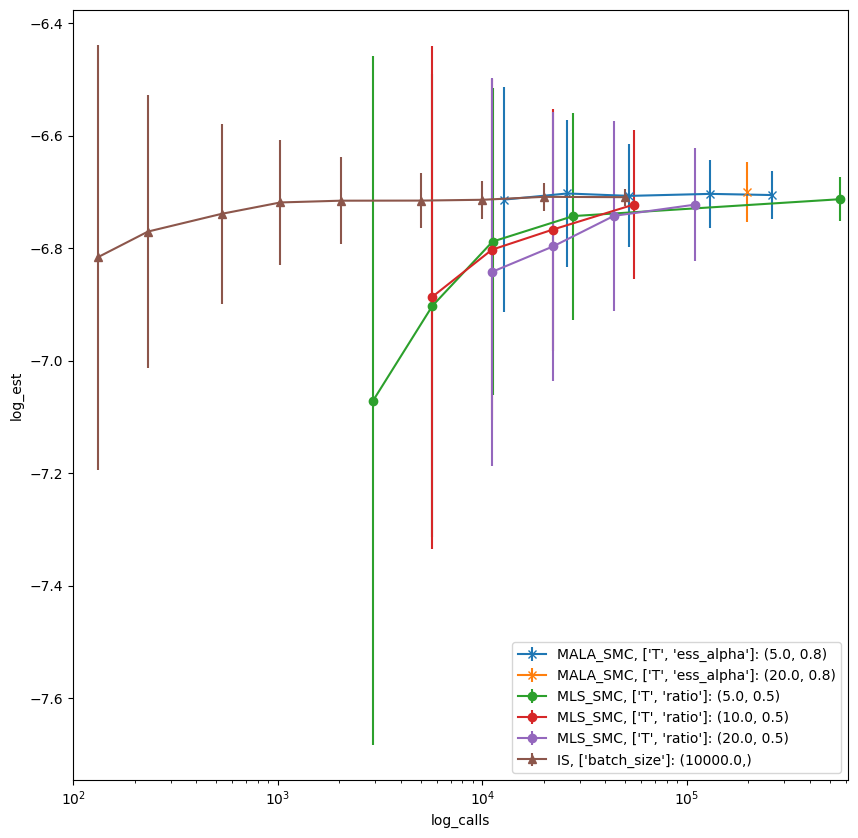

In [21]:
ref_data = utils.get_sel_df(agg_res_df,triplets=[('n_rep',n_rep_ref,'='),('epsilon',epsilon_range[0],'='),])
param_methods_dict = {'MLS_SMC':['T','N','alpha','ess_alpha'],
                      'MALA_SMC':['T','N','alpha','ess_alpha'],
                      'IS':['N','batch_size'],}
param_methods_ex_N = {'IS':['batch_size'],
                      'MLS_SMC':['T','ratio',],
                      'MALA_SMC':['T','ess_alpha',],
                      }
cond_methods_dict = {'MLS_SMC':[('T',5,'>='),('N',2,'>='),('ratio',0.5,'=='),('T',100,'<='),],
                     'MALA_SMC':[('T',5,'>='),('N',2,'>='),('ess_alpha',0.8,'=='),('T',100,'<=')],
                        'IS':[('batch_size',int(1e4),'>=')],
                                }

calls_max = 1e6
max_exp_by_method=3
ref_data['mean_log10_est'] = ref_data['mean_log_est']/np.log(10)
ref_data['std_log10_est'] = ref_data['std_log_est']/np.log(10)
mode_y = 'log10' 
x_variable = 'mean_calls'
if mode_y == 'log10':
    y_variable= 'mean_log10_est'
    y_error = 'std_log10_est'
    
elif mode_y == 'log':
    y_variable= 'mean_log_est'
    y_error = 'std_log_est'
else:
    y_variable= 'mean_est'
    y_error = 'std_est'
methods_grouped={}
max_calls=0
plot_traits = {'MLS_SMC':{'marker':'o',},
               'MALA_SMC':{'marker':'x',},
                'IS':{'marker':'^',},
                }

min_calls = 1e10
plt.figure(figsize=(10,10))
for method in ref_data['method_name'].unique():
    cond_method = cond_methods_dict[method]
    method_df = utils.get_sel_df(ref_data,triplets=[('method_name',method,'=')]+cond_method+[(x_variable,calls_max,'<=')])
    params = param_methods_ex_N[method]
    method_df_grouped = method_df.groupby(params)
    methods_grouped[method] = list(method_df_grouped)
    i = 0
    for values,df in method_df_grouped:
        if i > max_exp_by_method:
            break
        
        df = df.sort_values(by=x_variable)
        log_mean_calls = np.log(df[x_variable].values)
        plt.errorbar(df[x_variable],df[y_variable],yerr=df[y_error],
                     label=f"{method}, {params}: {values}",**plot_traits[method])
        plt.xscale('log')
        plt.ylabel('log_est')
        plt.xlabel('log_calls')
        i+=1
        max_calls=max(max_calls,df[x_variable].max())
        min_calls = min(min_calls,df[x_variable].min())
    plt.xlim([1e2,1.1*max_calls])
    plt.legend(loc='lower right')
    # for params_value in method_df[params].unique():
    #     print(f"method: {method}, params: {params}, params_value: {params_value}")
    # param_df = param_df.sort_values(by=x_variable)
    # plt.errorbar(param_df[x_variable],param_df['mean_est'],yerr=param_df[y_error],label=param)


In [83]:
methods_grouped['MALA_SMC'][0]

,method_name,from_gaussian,N,rho,n_rep,T,epsilon,alpha,min_rate,mean_time,...,batch_size,alpha_CI,sigma_bias,requires_gradG,requires_G,requires_model,requires_x_clean,search_method,mean_log10_est,std_log10_est
68,MALA_SMC,True,50,NaN,400,2.0,0.18,0.25,0.15,0.145200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.811346,0.315528
70,MALA_SMC,True,100,NaN,400,2.0,0.18,0.25,0.15,0.147554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.765979,0.232715
71,MALA_SMC,True,200,NaN,400,2.0,0.18,0.25,0.15,0.157179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.728024,0.160653
72,MALA_SMC,True,500,NaN,400,2.0,0.18,0.25,0.15,0.175094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.728943,0.109849


In [76]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(smc_pyt2)
reload(smc_config2)
reload(t_u2)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(is_pyt)
reload(is_config)
reload(mc_config)
reload(mc_pyt)

<module 'stat_reliability_measure.dev.mc.mc_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/mc/mc_pyt.py'>

with parameters in {'N_range': [50, 100, 200, 500], 'T_range': [2, 5], 'ess_alpha_range': [0.8], 'alpha_range': [0.25], 'L_range': [1]}
Experiment already done for method: MALA_SMC
Starting MALA_SMC simulation 1/8, with model: mnist_model, img_idx:0,eps:0.18,


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:32<00:00,  4.30it/s]


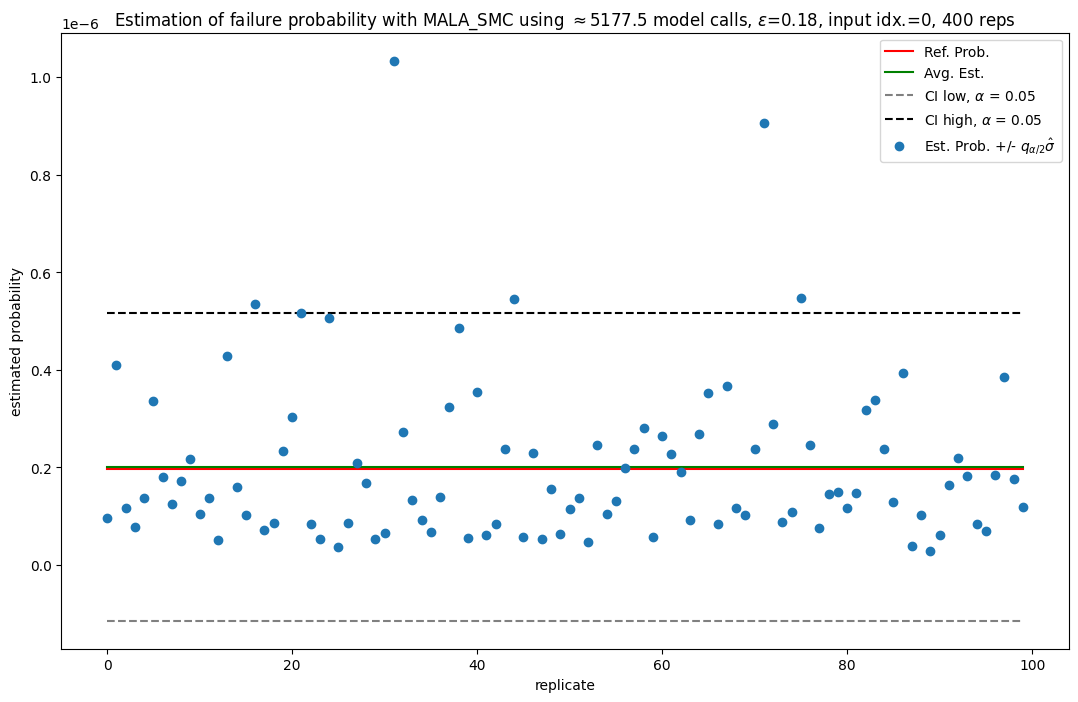

mean est:2.0169268451386558e-07, std est:1.6105199906089357e-07
mean calls:5177.5
std. re.:3959002.9649429307
std. rel. adj.:20497737850.992023
mean rel. error:0.5971435375783832
std rel. error:0.5658314027667789
stat performance (per 1k calls):2.929592087824998
Experiment already done for method: MALA_SMC
Starting MALA_SMC simulation 2/8, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [02:29<00:00,  2.68it/s]


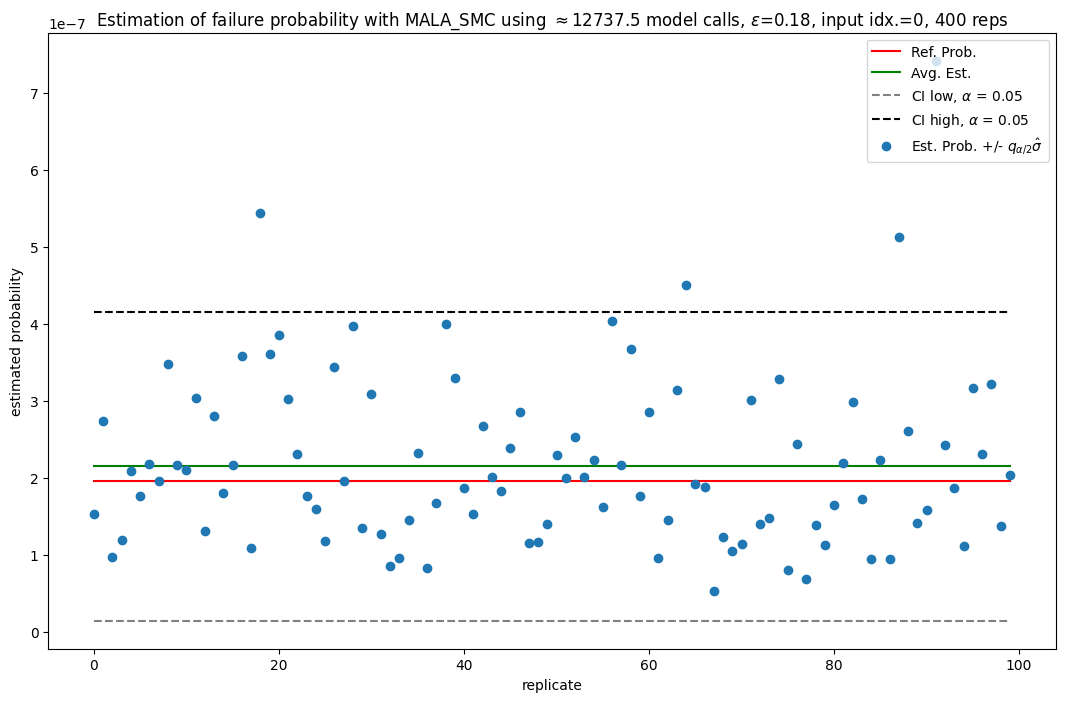

mean est:2.1483803376298737e-07, std est:1.0225059002249493e-07
mean calls:12737.5
std. re.:2215355.7907753806
std. rel. adj.:28218094385.00141
mean rel. error:0.3881661556207156
std rel. error:0.3620882608259224
stat performance (per 1k calls):4.612099222270187
Experiment already done for method: MALA_SMC
Starting MALA_SMC simulation 3/8, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:33<00:00,  4.27it/s]


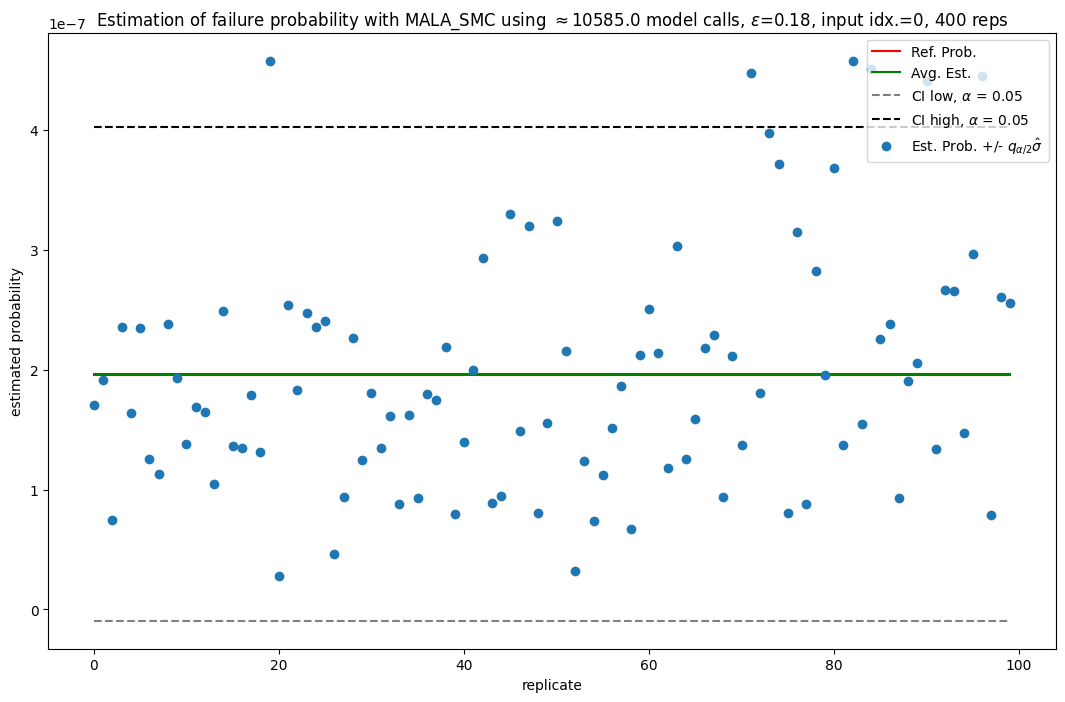

mean est:1.966384668339316e-07, std est:1.0515199292160935e-07
mean calls:10585.0
std. re.:2719446.6881498178
std. rel. adj.:28785343194.065823
mean rel. error:0.4089387565566933
std rel. error:0.34770513727723706
stat performance (per 1k calls):3.6804588780795546
Experiment already done for method: MALA_SMC
Skipping MALA_SMC run 4/8, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ess_alpha: 0.8: alpha: 0.25: L: 1
Experiment already done for method: MALA_SMC
Starting MALA_SMC simulation 5/8, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:38<00:00,  4.07it/s]


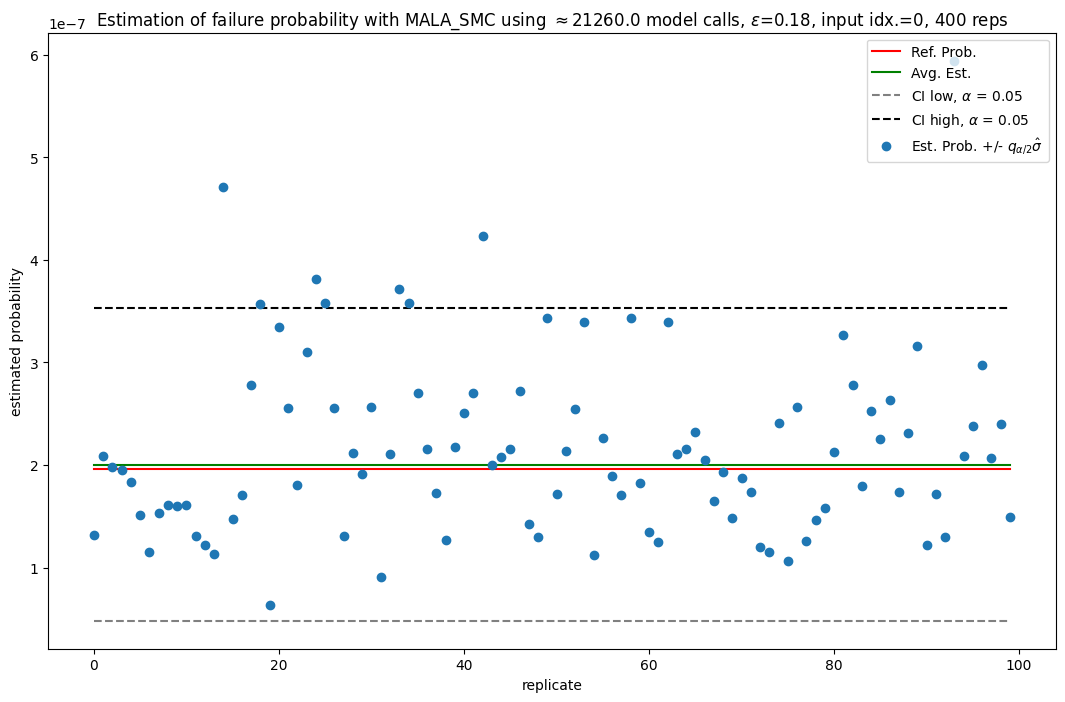

mean est:2.0042037448320117e-07, std est:7.766381781992305e-08
mean calls:21260.0
std. re.:1933459.1348853256
std. rel. adj.:41105341207.66202
mean rel. error:0.3001648453754384
std rel. error:0.2600064788781727
stat performance (per 1k calls):5.527737740949951
Experiment already done for method: MALA_SMC
Skipping MALA_SMC run 6/8, with model: mnist_model, img_idx:0,eps:0.18,N: 200: T: 5: ess_alpha: 0.8: alpha: 0.25: L: 1
Experiment already done for method: MALA_SMC
Starting MALA_SMC simulation 7/8, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:49<00:00,  3.66it/s]


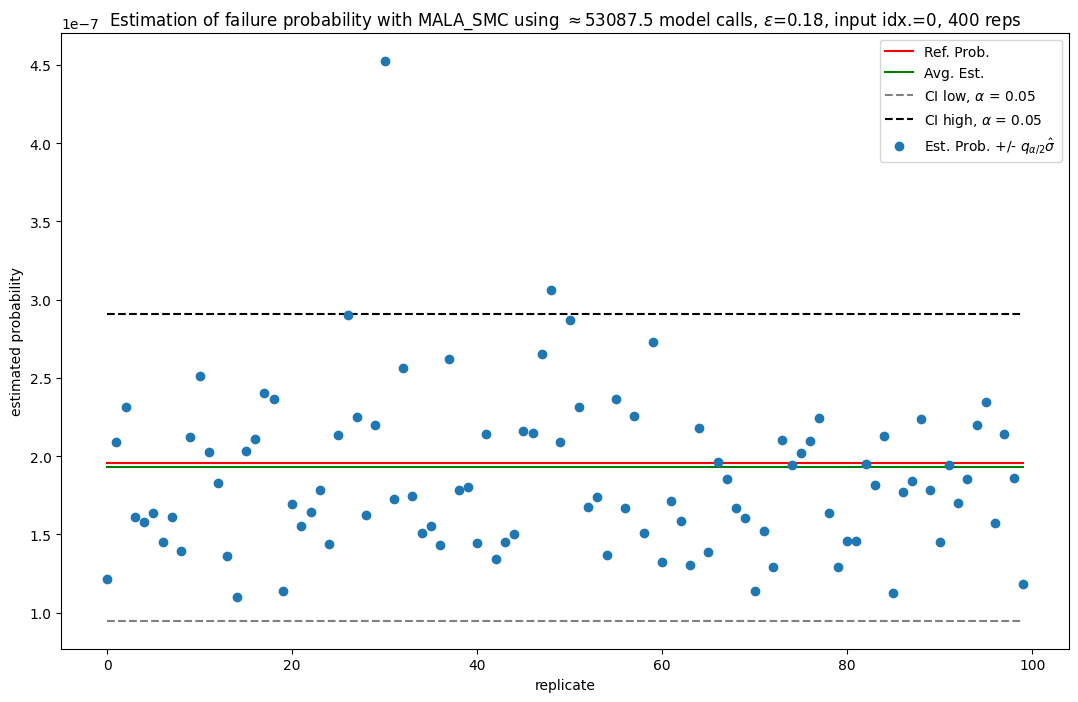

mean est:1.9276392436040623e-07, std est:4.9971043850184514e-08
mean calls:53087.5
std. re.:1344828.4963919518
std. rel. adj.:71393582802.20775
mean rel. error:0.20211200456096334
std rel. error:0.1564453640011318
stat performance (per 1k calls):8.305293261410084
Experiment already done for method: MALA_SMC
Skipping MALA_SMC run 8/8, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 5: ess_alpha: 0.8: alpha: 0.25: L: 1
p_fail_mala=2.012706967908784e-07


In [79]:
N_range_low = [50,100,200,500]
N_range_high = [1000,2000,5000,10000]
N_range = N_range_low + N_range_high

p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=400, verbose=0, track_accept=False,ess_alpha_range=[0.8],
                        alpha=0.25, L_range=[1], only_duplicated=False,p_ref=p_ref,
                         N_range=N_range_low,T_range=[2,5],epsilon_range=epsilon_range,
                         repeat_exp=False,
 )


exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

In [22]:
p_fail_webb,dict_out=run_exp.run_est(model=model,method='amls_webb',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=100, update_aggr_res=False,
                         N_range=[300],T_range=[1000,],ratio_range=[0.5,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0 ,)
exp_config,method_config_webb, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_webb=dict_out['results_df']
print(f"p_fail_webb={p_fail_webb}")

model accuracy on sample batch:1.0
Running reliability experiments on architecture custom trained on mnist.
Testing uniform noise pertubation with epsilon in [0.18]
ModelExperimentConfig configuration: 
 config( adversarial_every=1, aggr_res_path=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_mnist/aggr_res.csv, allow_multi_gpu=True, attack=PGD, clip_max=1_0, clip_min=0_0, commit=15d53c4d0e4f3b0d0b70b9248b4174ba83c9e854, data_dir=/home/karimtito/repos/stat_reliability_measure/data, dataset=mnist, device=cuda:0, download=True, eps_max=0_18, eps_min=0_18, eps_num=1, epsilon=0_18, exp_log_path=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_mnist/raw_logs/MLS_Webb/MLS_Webb_2023_11_14T11_56_11, exp_name=, export_to_onnx=False, force_train=False, from_gaussian=True, input_start=0, input_stop=1, lirpa_bounds=False, lirpa_cert=False, load_batch_size=128, loc_time=2023_11_14T11_56_11, log_dir=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_mnist, log_

  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: multilevel_uniform() got an unexpected keyword argument 'V'

with parameters in {'N_range': [50, 100, 200, 500], 'T_range': [2, 5, 10, 20], 'ratio_range': [0.5], 's_range': [1.0]}
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 1/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:09<00:00, 40.80it/s]


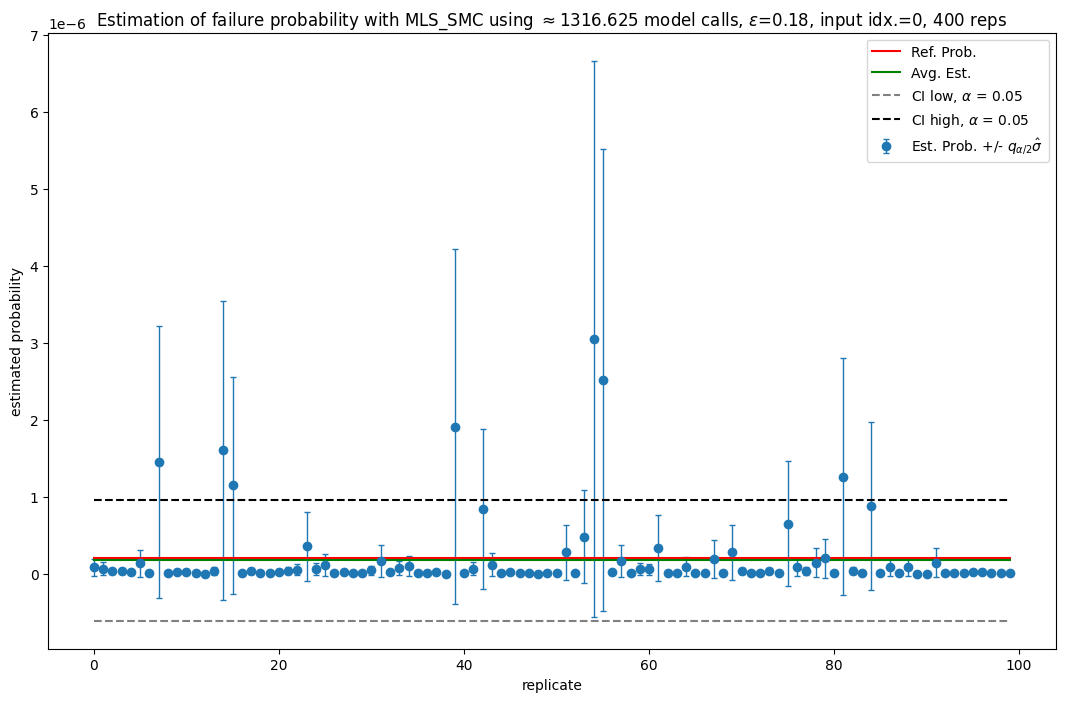

mean est:1.6928828439404243e-07, std est:3.9944172397959576e-07
mean calls:1316.625
std. re.:13937973.0326981
std. rel. adj.:18351083744.176136
mean rel. error:1.2307264385460015
std rel. error:1.6313570649630997
stat performance (per 1k calls):2.1478854956570412
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 2/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:32<00:00, 12.18it/s]


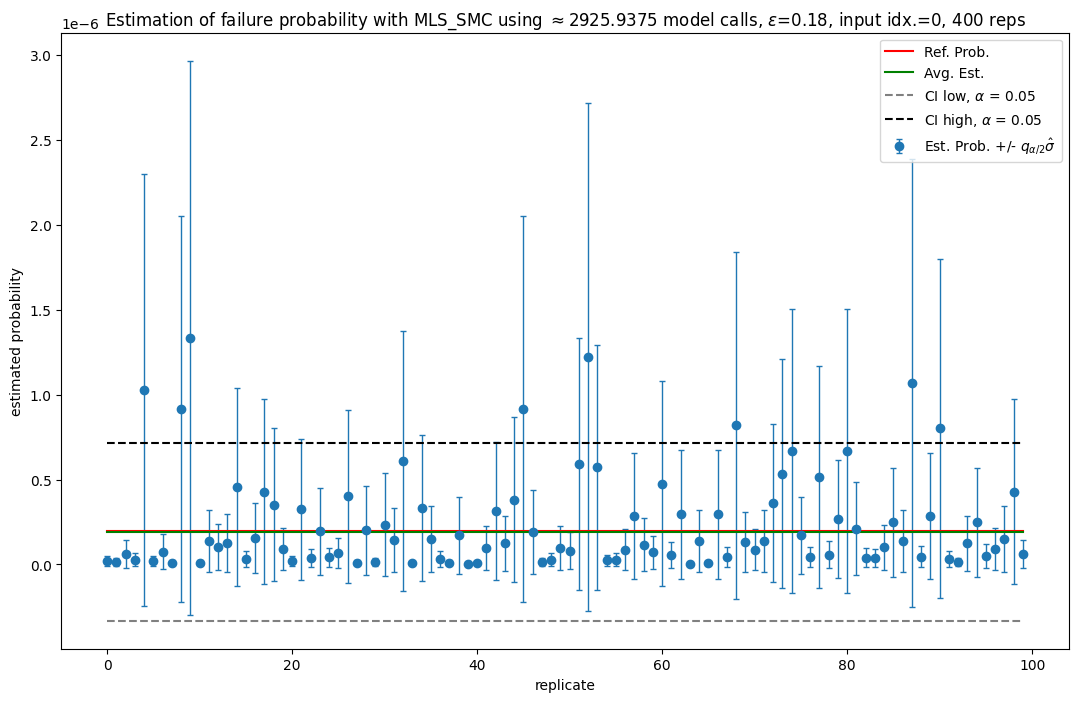

mean est:1.909439451992512e-07, std est:2.663337881831638e-07
mean calls:2925.9375
std. re.:7304903.501709254
std. rel. adj.:21373691089.53242
mean rel. error:0.9056282248428144
std rel. error:1.0143113723253072
stat performance (per 1k calls):2.9678116809630786
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 3/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:41<00:00,  9.55it/s]


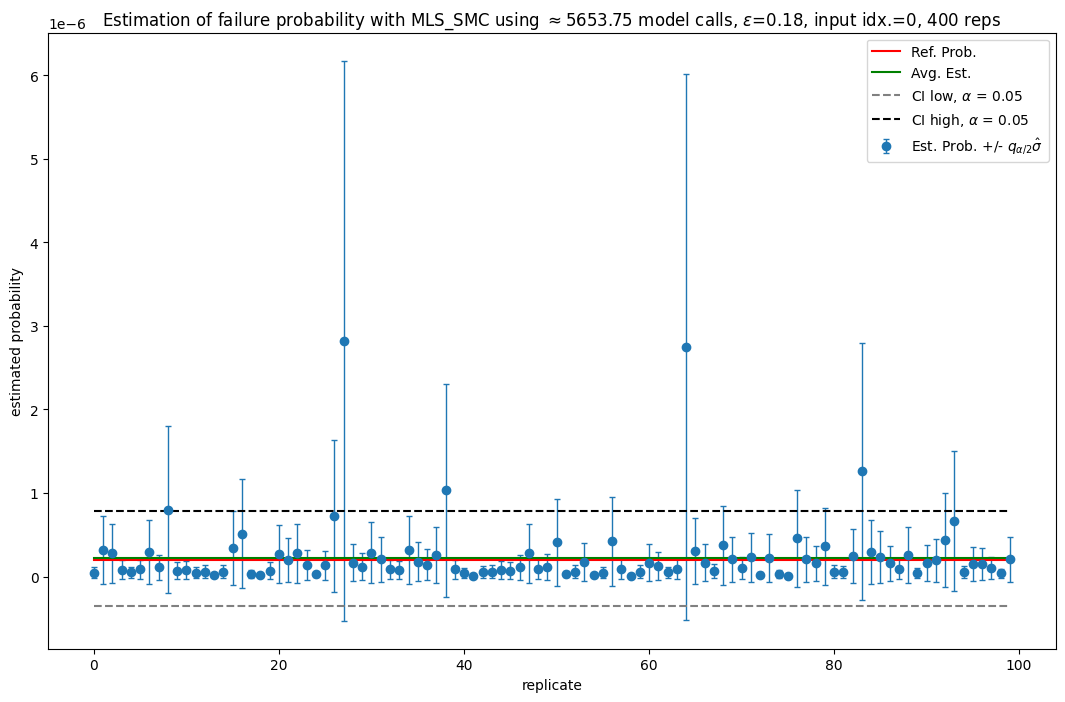

mean est:2.161310985684395e-07, std est:2.912056264655255e-07
mean calls:5653.75
std. re.:6233977.6364936745
std. rel. adj.:35245351062.32611
mean rel. error:0.7919050292768859
std rel. error:1.2622365446613986
stat performance (per 1k calls):7.136369864379382
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 4/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:12<00:00,  5.53it/s]


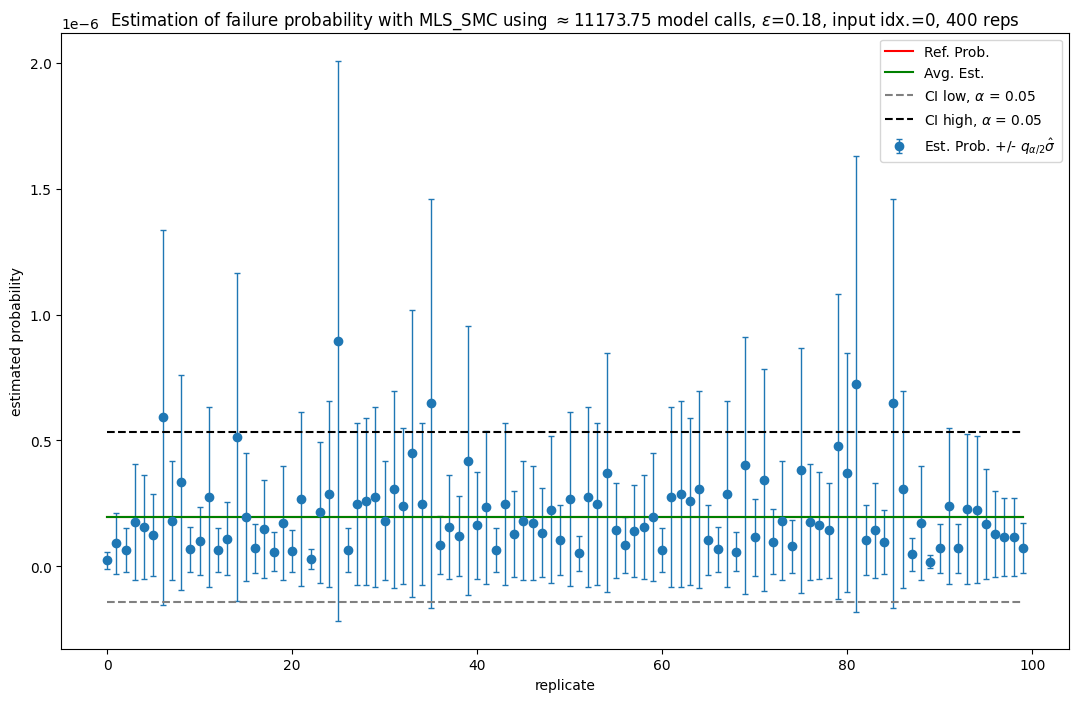

mean est:1.957714557647705e-07, std est:1.724841920091034e-07
mean calls:11173.75
std. re.:4500394.218323437
std. rel. adj.:50286279896.9915
mean rel. error:0.609230335705675
std rel. error:0.635663683733615
stat performance (per 1k calls):7.102747086118481
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 5/16, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 6/16, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 7/16, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 10: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 8/16, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 20: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 9/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:08<00:00, 46.85it/s]


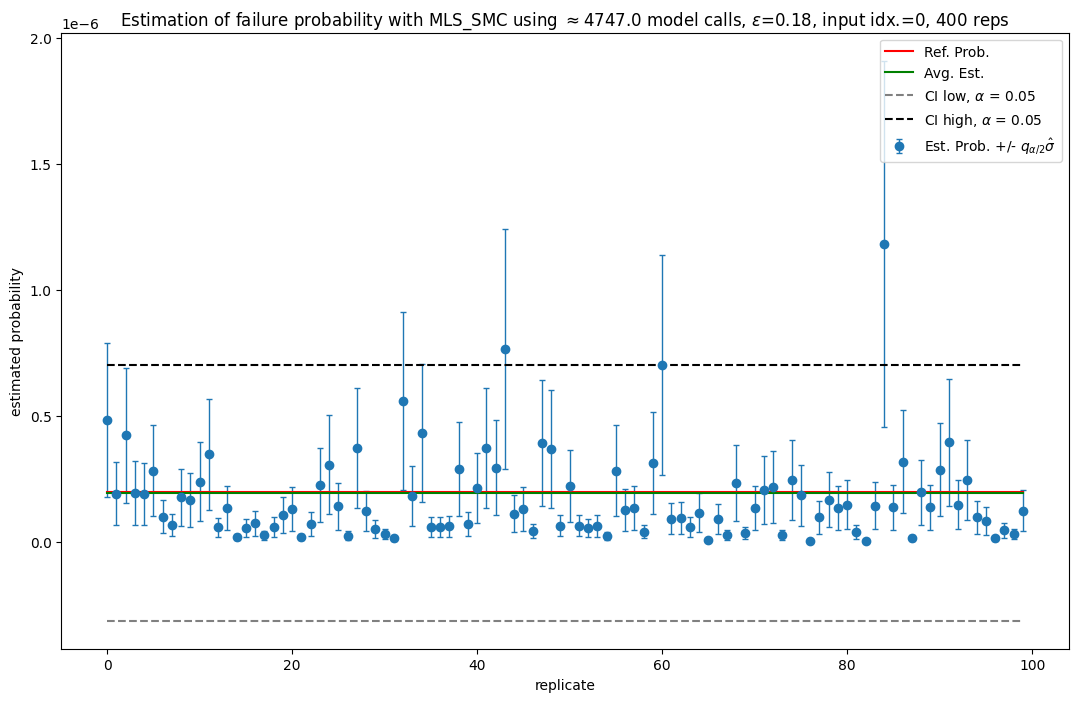

mean est:1.9243117421865463e-07, std est:2.5839552715638384e-07
mean calls:4747.0
std. re.:6978050.881458599
std. rel. adj.:33124807534.28397
mean rel. error:0.8228840908246445
std rel. error:1.0310114880878338
stat performance (per 1k calls):4.894211533952947
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 10/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:20<00:00, 19.11it/s]


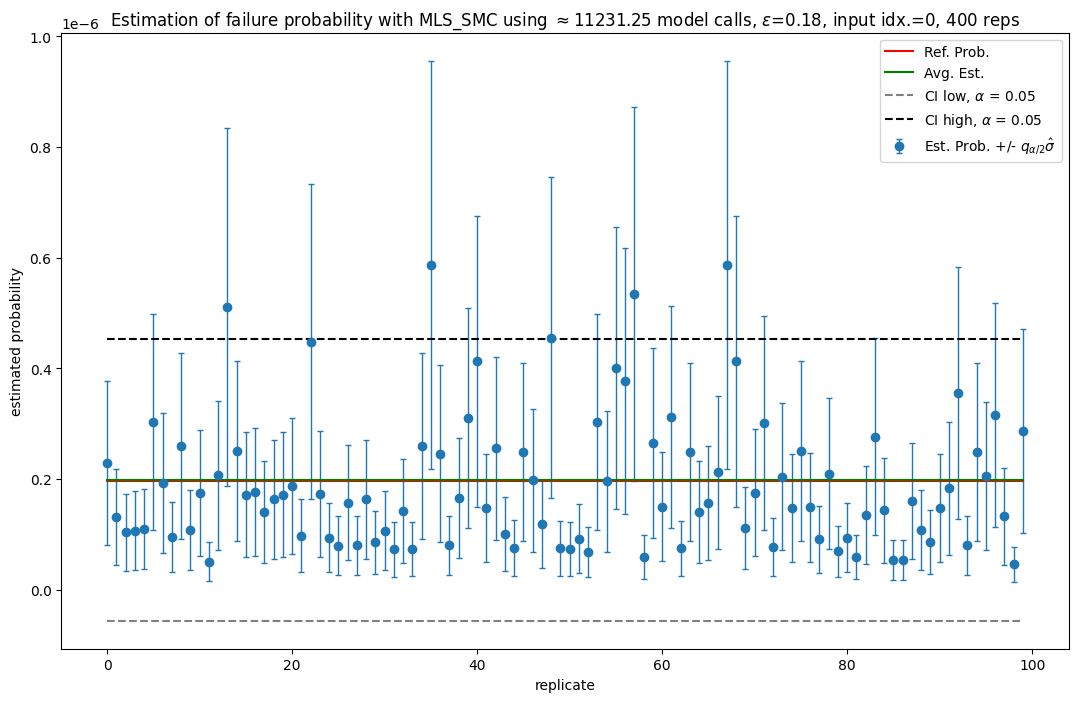

mean est:1.9819363951683046e-07, std est:1.2977570970104538e-07
mean calls:11231.25
std. re.:3303801.8103424963
std. rel. adj.:37105824082.409164
mean rel. error:0.5027684311097967
std rel. error:0.4315245514106527
stat performance (per 1k calls):4.846560118030893
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 11/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:38<00:00, 10.41it/s]


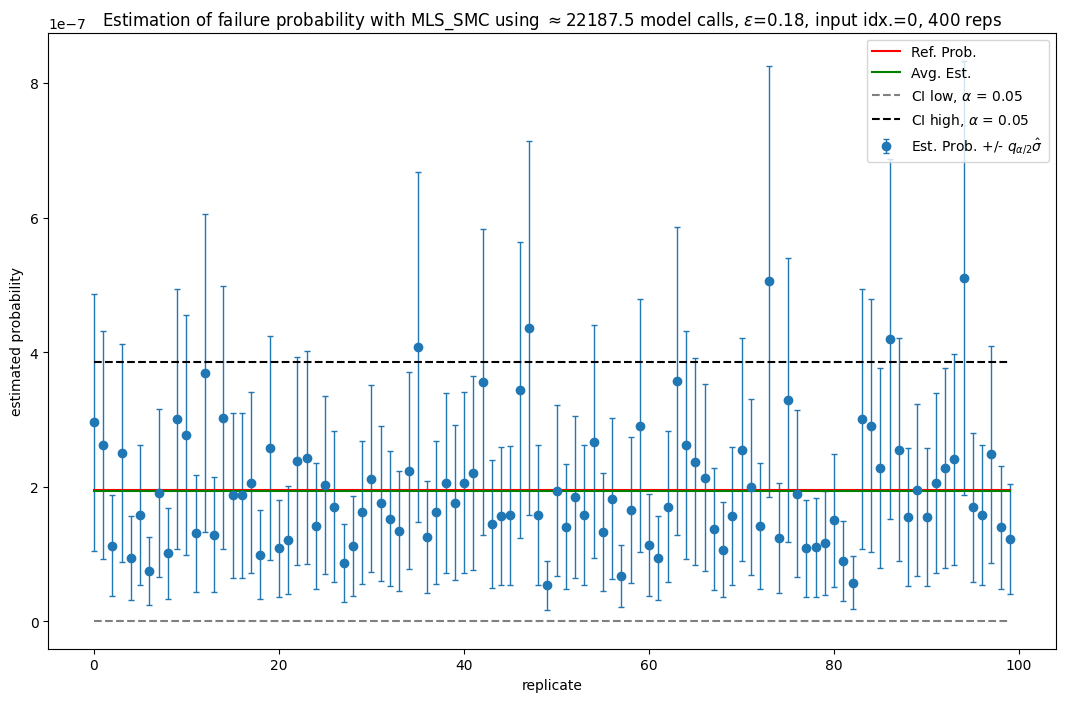

mean est:1.9316524267196654e-07, std est:9.810275229598502e-08
mean calls:22187.5
std. re.:2629197.5792903756
std. rel. adj.:58335321290.50521
mean rel. error:0.38683383775988
std rel. error:0.3183317809251812
stat performance (per 1k calls):7.062986389277459
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 12/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:57<00:00,  6.95it/s]


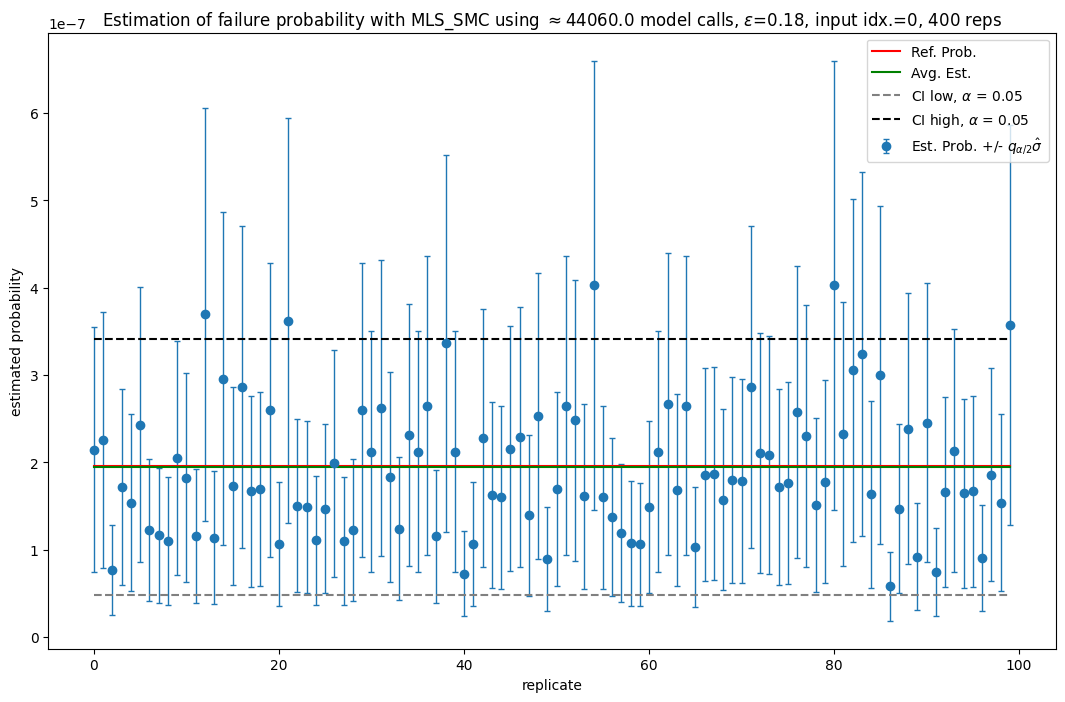

mean est:1.948118209838867e-07, std est:7.464456606812591e-08
mean calls:44060.0
std. re.:1966833.4507699492
std. rel. adj.:86658681840.92397
mean rel. error:0.30030498298777153
std rel. error:0.23459514762868464
stat performance (per 1k calls):10.336262204519846
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 13/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:07<00:00, 51.63it/s]


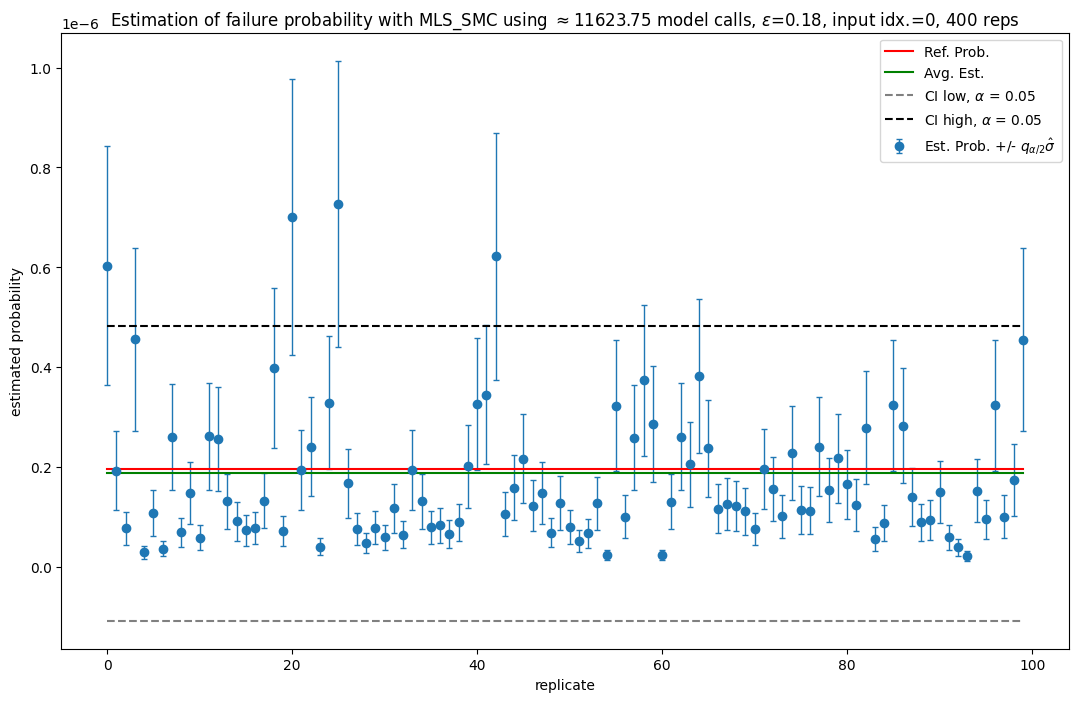

mean est:1.865479350090027e-07, std est:1.5058488419258538e-07
mean calls:11623.75
std. re.:4327135.424363711
std. rel. adj.:50297540388.947685
mean rel. error:0.5595339041800359
std rel. error:0.529220343089638
stat performance (per 1k calls):6.151524962988178
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 14/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:18<00:00, 22.14it/s]


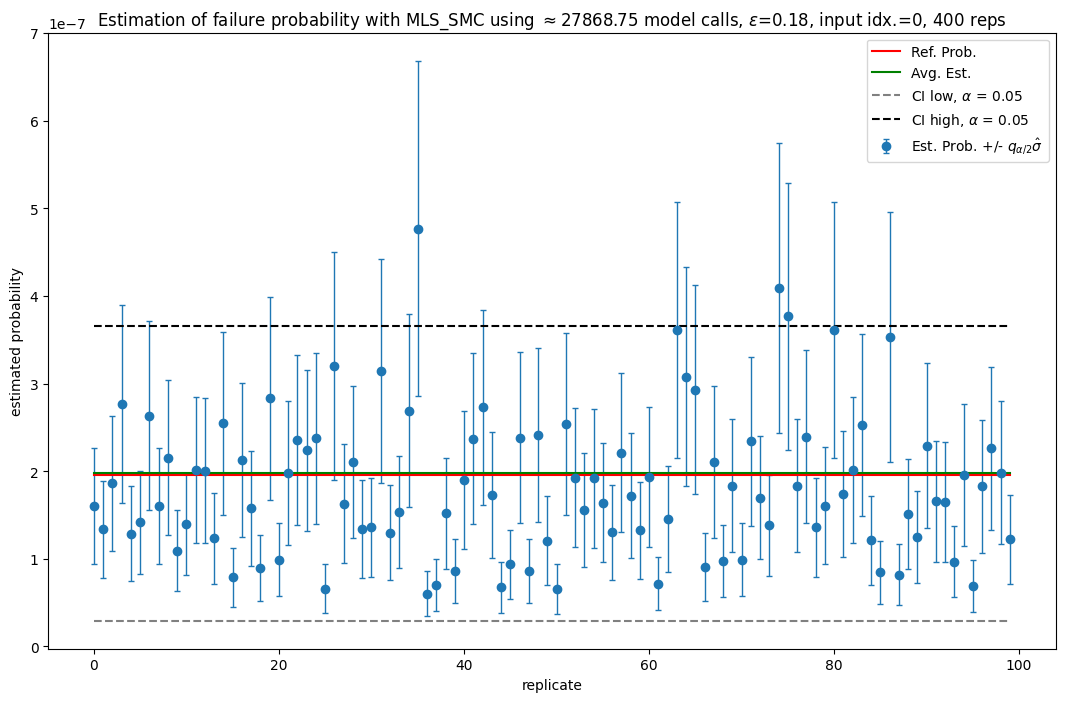

mean est:1.9769489765167236e-07, std est:8.587332019229713e-08
mean calls:27868.75
std. re.:2197188.581533118
std. rel. adj.:61232899281.60109
mean rel. error:0.33798540918737885
std rel. error:0.27929066977912453
stat performance (per 1k calls):7.783481853406976
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 15/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:35<00:00, 11.36it/s]


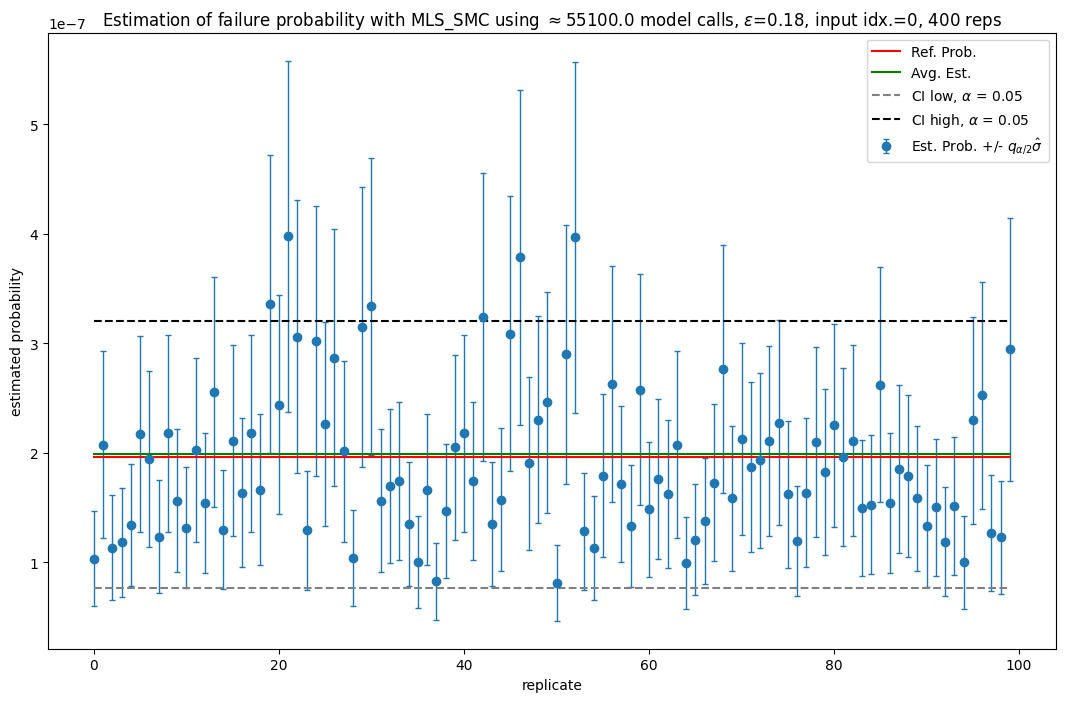

mean est:1.986801624298096e-07, std est:6.219020759336494e-08
mean calls:55100.0
std. re.:1575480.360507255
std. rel. adj.:86808967863.94975
mean rel. error:0.24668604906703437
std rel. error:0.20031907051838366
stat performance (per 1k calls):11.03758078556294
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 16/16, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:06<00:00,  6.05it/s]


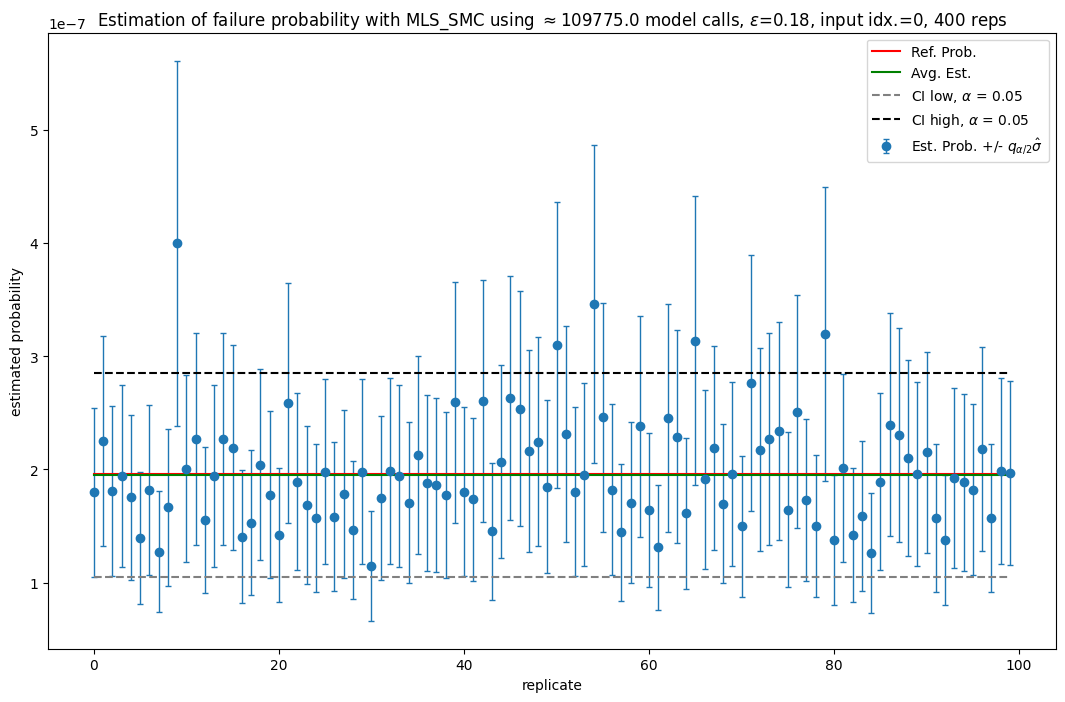

mean est:1.9471287727355957e-07, std est:4.59785583022356e-08
mean calls:109775.0
std. re.:1212735.248570528
std. rel. adj.:133128011911.82973
mean rel. error:0.18421318253429061
std rel. error:0.14556223098081064
stat performance (per 1k calls):15.97909390591849
p_fail_mls: 1.9403104447349052e-07


In [78]:
N_range_low = [50,100,200,500]
N_range_high = [1000,2000,5000,10000]
N_range = N_range_low + N_range_high
T_range_low= [2,5,10,20]
T_range_high = [50,100,200,500]
T_range = T_range_low + T_range_high
p_fail_mls,dict_out=run_exp.run_est(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=400, update_aggr_res=True, 
                         N_range=N_range_low,T_range=T_range_low,ratio_range=[0.5,],repeat_exp=False,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

with parameters in {'N_range': [100, 200, 500, 1000, 2000], 'batch_size_range': [10000]}
Experiment already done for method: IS
Starting IS simulation 1/5, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:05<00:00, 70.83it/s]


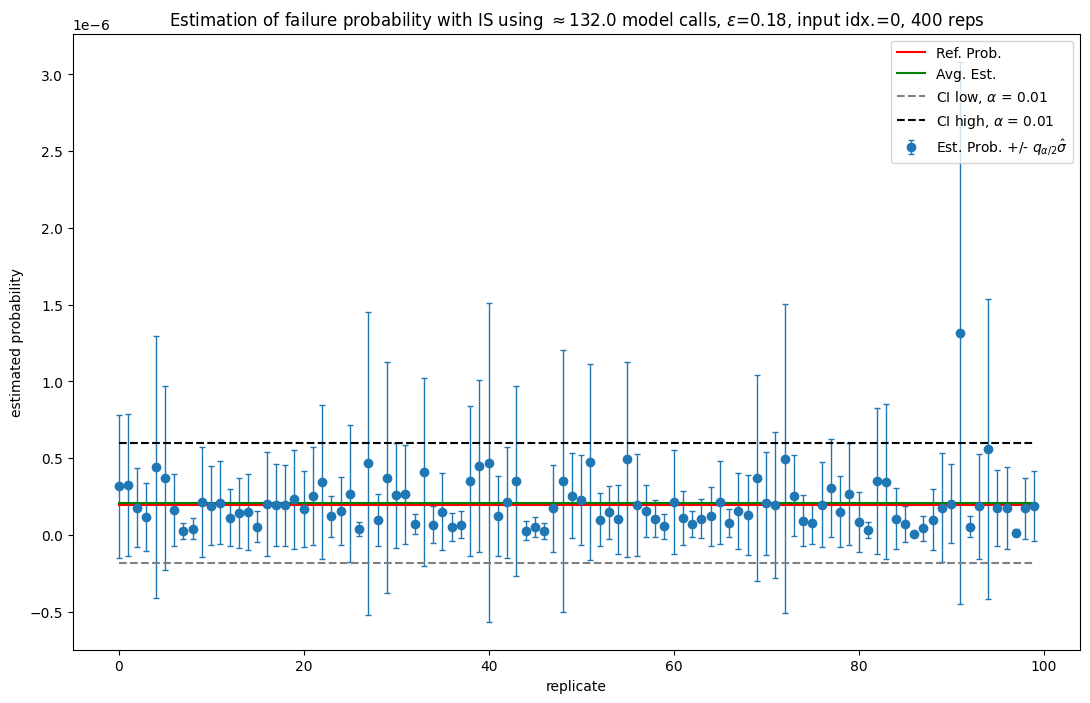

mean est:2.055881651585878e-07, std est:1.5153493393427198e-07
mean calls:132.0
std. re.:3585226.0463657165
std. rel. adj.:473249838.1202746
mean rel. error:0.5724254846572876
std rel. error:0.5226160287857056
stat performance (per 1k calls):0.06898531579971313
Experiment already done for method: IS
Starting IS simulation 2/5, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:06<00:00, 59.20it/s]


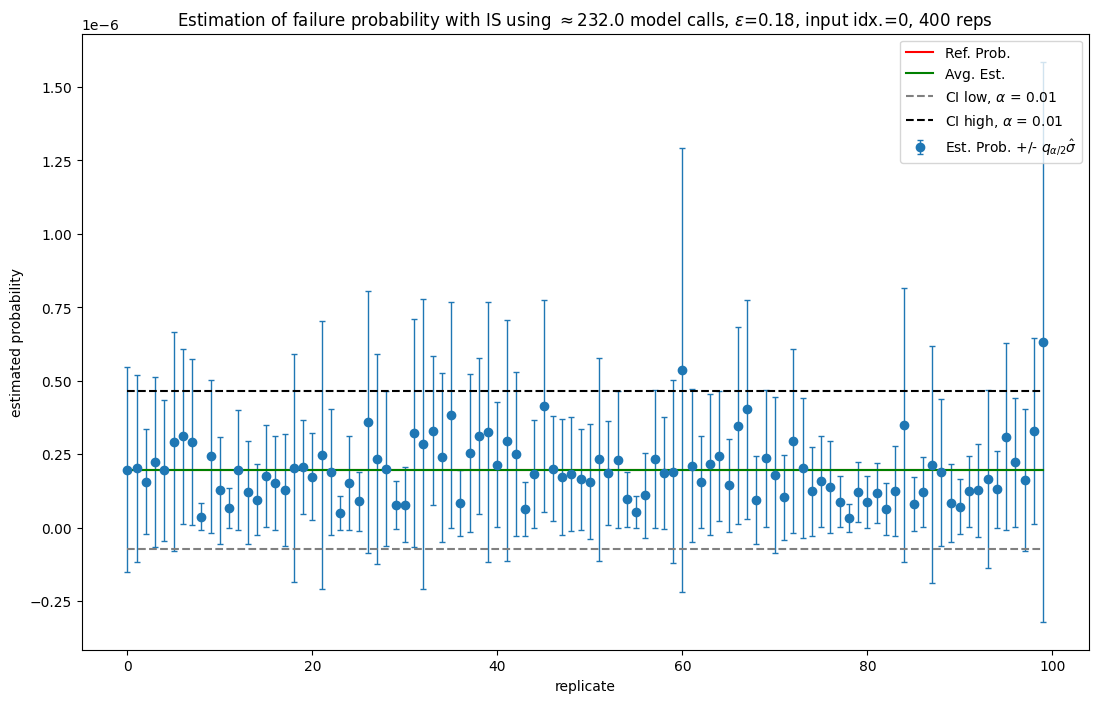

mean est:1.9614904545051104e-07, std est:1.0435886821369422e-07
mean calls:232.0
std. re.:2712420.1529599964
std. rel. adj.:629281475.4867191
mean rel. error:0.4132327139377594
std rel. error:0.33619341254234314
stat performance (per 1k calls):0.07799687170982361
Experiment already done for method: IS
Starting IS simulation 3/5, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:05<00:00, 71.57it/s]


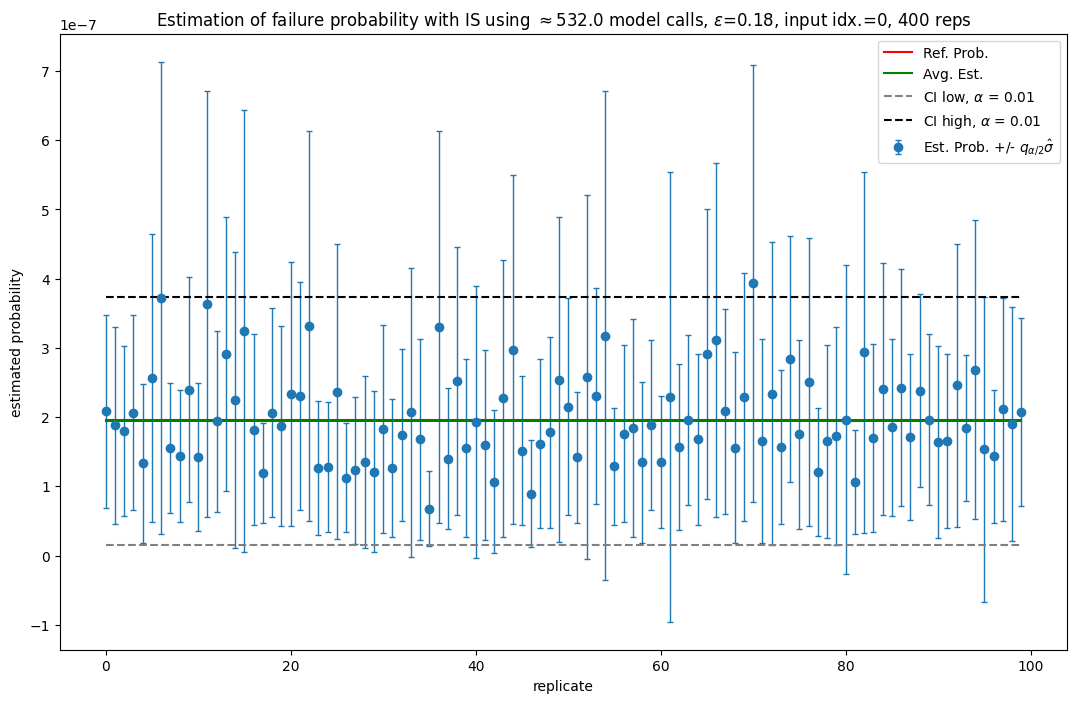

mean est:1.9481007029753528e-07, std est:6.951420772338679e-08
mean calls:532.0
std. re.:1831684.925283378
std. rel. adj.:974456380.2507571
mean rel. error:0.28088340163230896
std rel. error:0.21691212058067322
stat performance (per 1k calls):0.11539724814891816
Experiment already done for method: IS
Starting IS simulation 4/5, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:06<00:00, 66.56it/s]


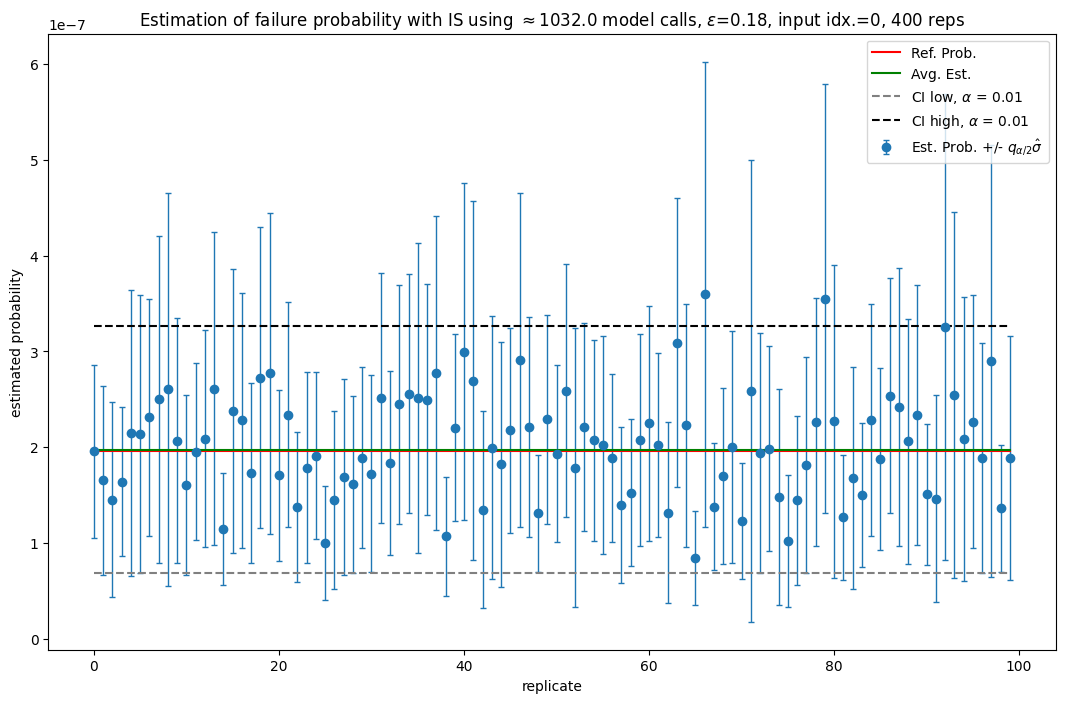

mean est:1.9756842561946542e-07, std est:5.0211848900971745e-08
mean calls:1032.0
std. re.:1286385.4971151727
std. rel. adj.:1327549833.0228581
mean rel. error:0.20332622528076172
std rel. error:0.1562938541173935
stat performance (per 1k calls):0.1612952574491501
Experiment already done for method: IS
Starting IS simulation 5/5, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:07<00:00, 55.09it/s]


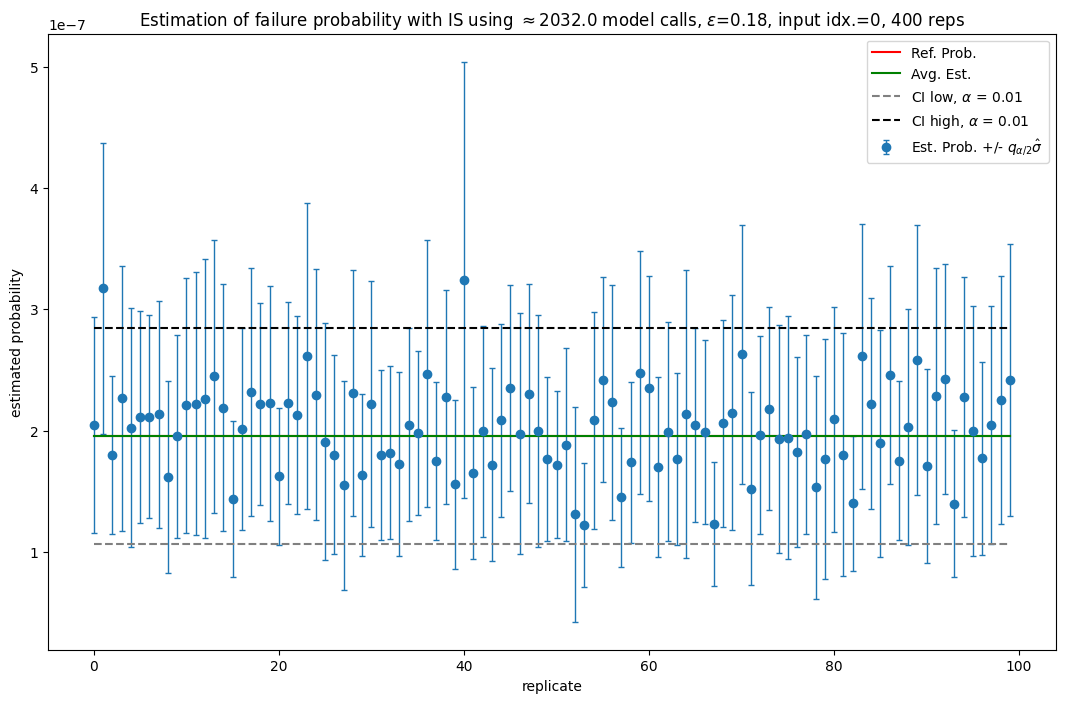

mean est:1.95665634805664e-07, std est:3.4594201281379355e-08
mean calls:2032.0
std. re.:903595.7830931061
std. rel. adj.:1836106631.2451916
mean rel. error:0.13847601413726807
std rel. error:0.10959146171808243
stat performance (per 1k calls):0.2226898502111435
p_fail_mls: 1.979562682663527e-07


In [63]:
N_range_high=[5000,10000,20000,50000,10000]
N_range_low = [100,200,500,1000,2000,]
p_fail_mls,dict_out=run_exp.run_est(model=model,method='is',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=400, update_aggr_res=True, 
                         N_range=N_range_low,batch_size_range=[10000],repeat_exp=False,alpha_CI=0.01,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref,sigma_bias=1.)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

with parameters in {'N_range': [100, 100, 10000], 'T_range': [2, 5, 10, 20], 'ratio_range': [0.2, 0.5, 0.8], 's_range': [1.0]}
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 1/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:03<00:00, 110.30it/s]


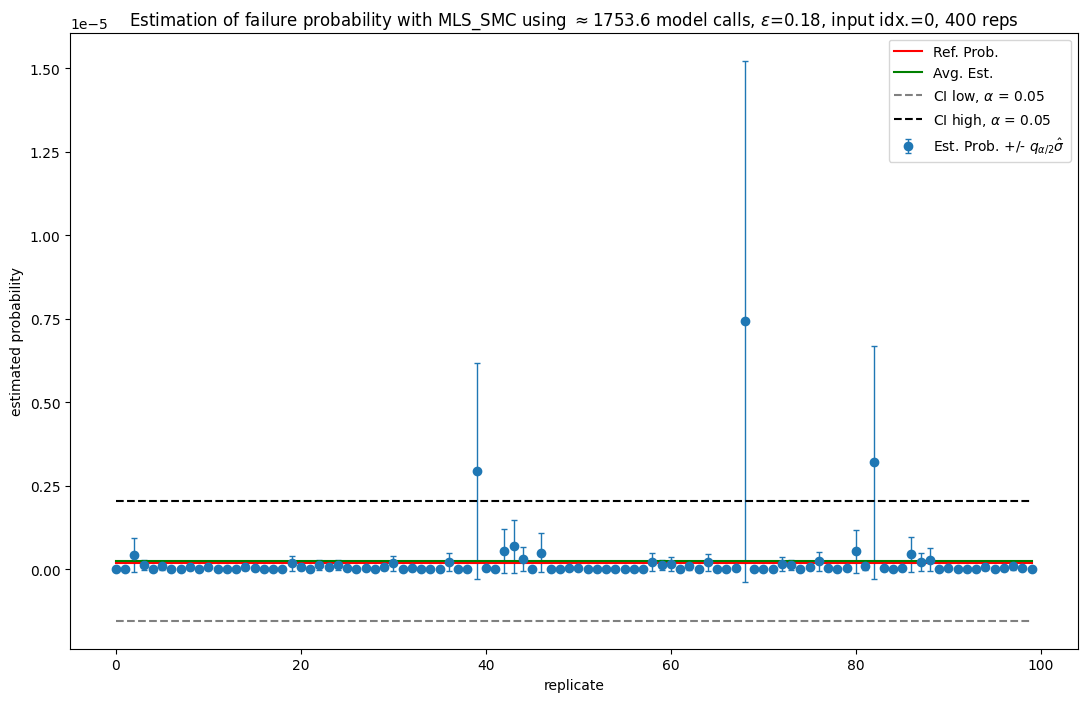

mean est:2.5447429269094413e-07, std est:9.130619251906983e-07
mean calls:1753.6
std. re.:14099782.103787187
std. rel. adj.:24725377897.20121
mean rel. error:1.5945627399173044
std rel. error:4.419012451802254
stat performance (per 1k calls):7.7491802354804316
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 2/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 3/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:23<00:00, 17.28it/s]


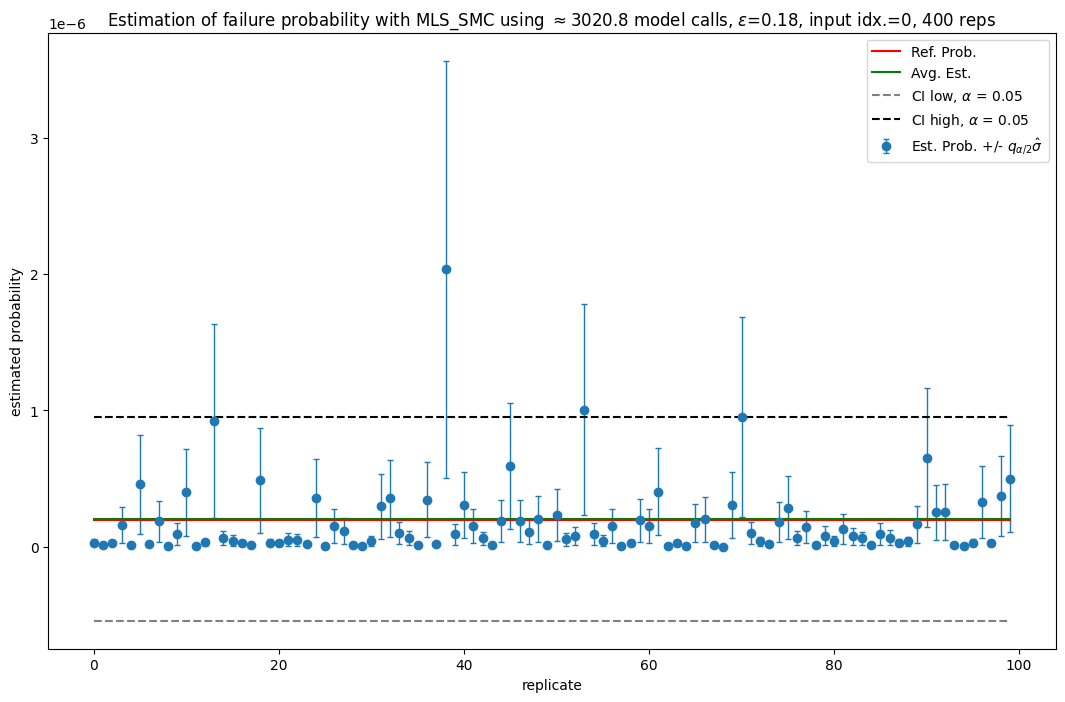

mean est:2.030089310665433e-07, std est:3.806595363073075e-07
mean calls:3020.8
std. re.:9236478.535736648
std. rel. adj.:27901554360.75327
mean rel. error:0.9982970764717206
std rel. error:1.6807389906467884
stat performance (per 1k calls):5.077176342945819
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 4/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:06<00:00, 58.53it/s]


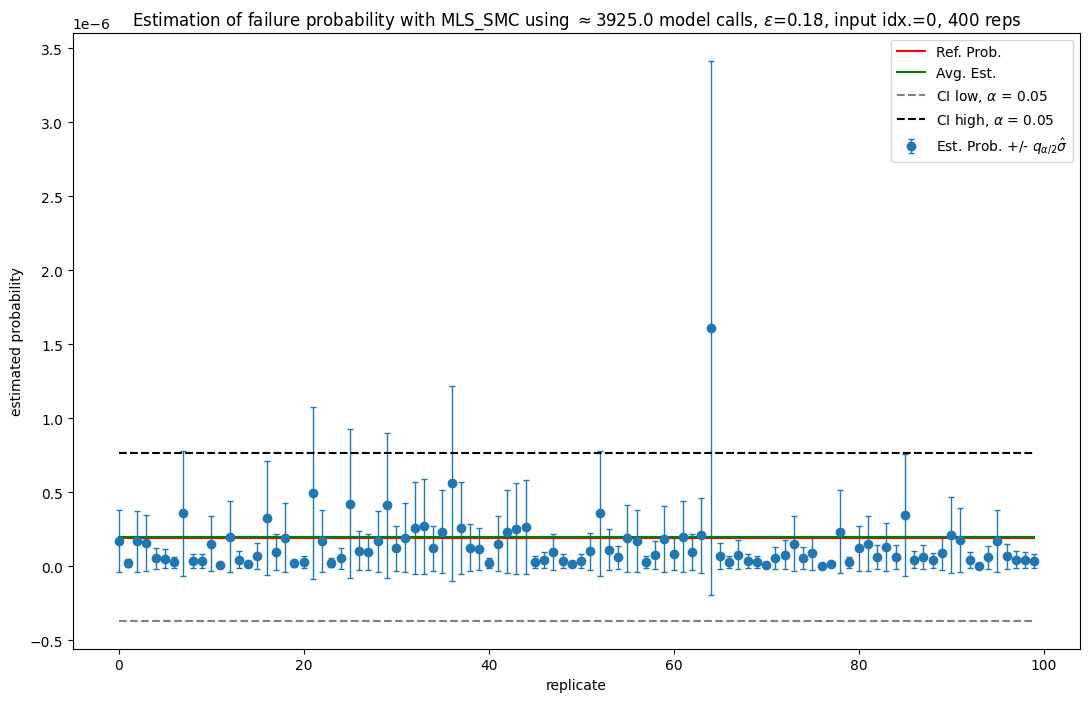

mean est:1.989755904000001e-07, std est:2.8851231379920513e-07
mean calls:3925.0
std. re.:7287268.13511654
std. rel. adj.:28602527430.33242
mean rel. error:0.9049656185190745
std rel. error:1.172919647827694
stat performance (per 1k calls):4.603709617723698
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 5/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 6/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:47<00:00,  8.44it/s]


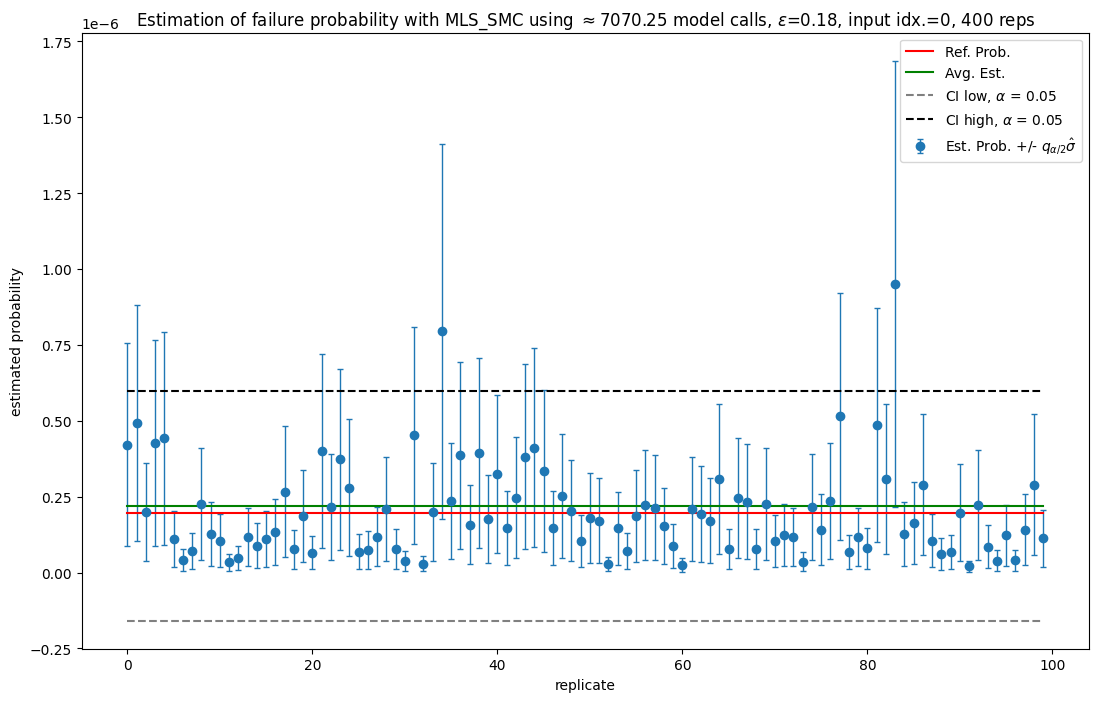

mean est:2.2047144103928907e-07, std est:1.934614938901134e-07
mean calls:7070.25
std. re.:3980062.1663511163
std. rel. adj.:28140034531.64398
mean rel. error:0.6768347590548217
std rel. error:0.7388596741125915
stat performance (per 1k calls):5.223922610894549
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 7/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:12<00:00, 32.06it/s]


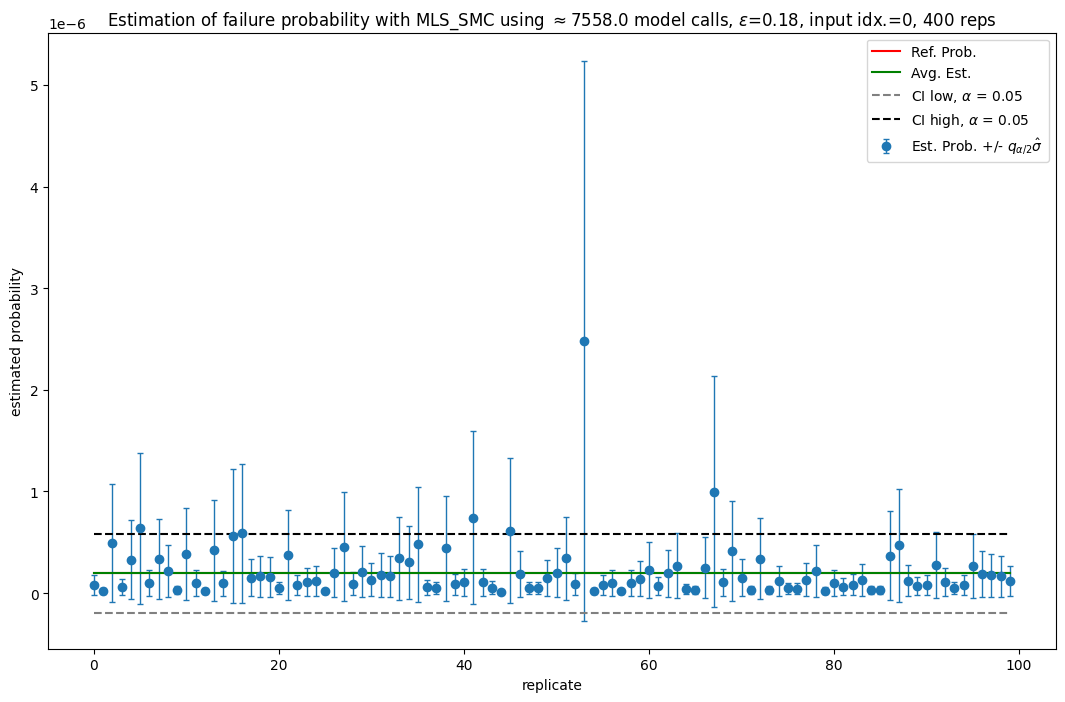

mean est:1.9587737600000007e-07, std est:1.9896309938591392e-07
mean calls:7558.0
std. re.:5185659.330397955
std. rel. adj.:39193213219.14774
mean rel. error:0.6313136119643885
std rel. error:0.803114793544009
stat performance (per 1k calls):6.06994160960562
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 8/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 10: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 9/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:27<00:00,  4.58it/s]


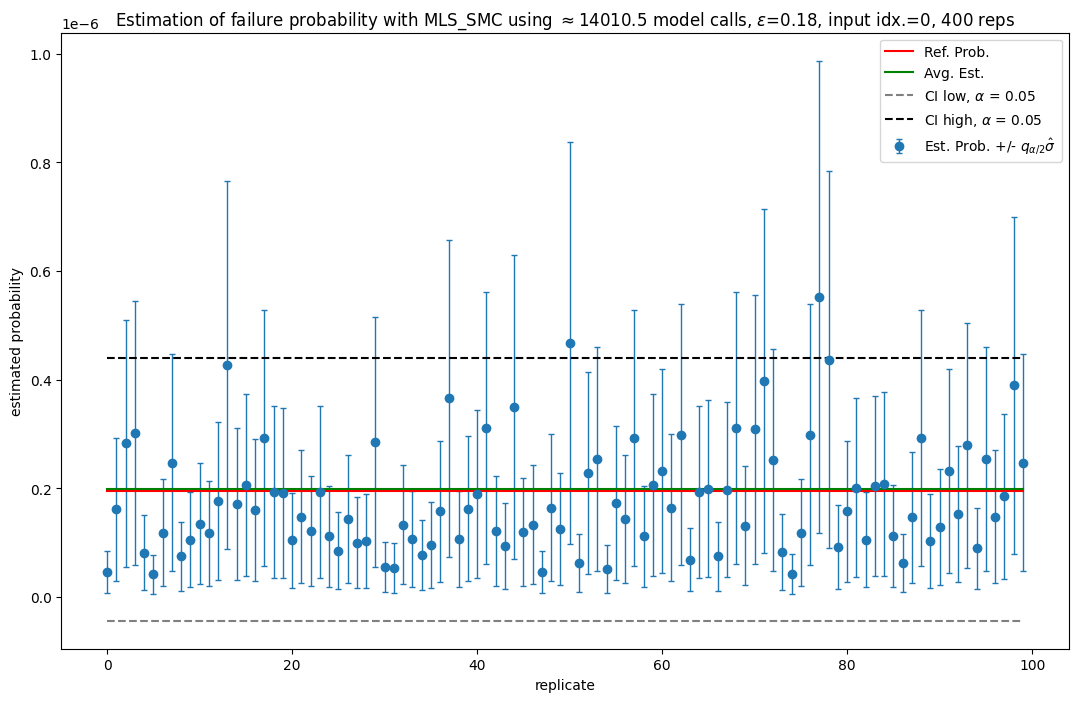

mean est:1.980917854243897e-07, std est:1.2330792795735818e-07
mean calls:14010.5
std. re.:3142375.4075376876
std. rel. adj.:44026250647.30677
mean rel. error:0.4850195461083376
std rel. error:0.40725335476123237
stat performance (per 1k calls):5.705823126882247
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 10/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:23<00:00, 17.05it/s]


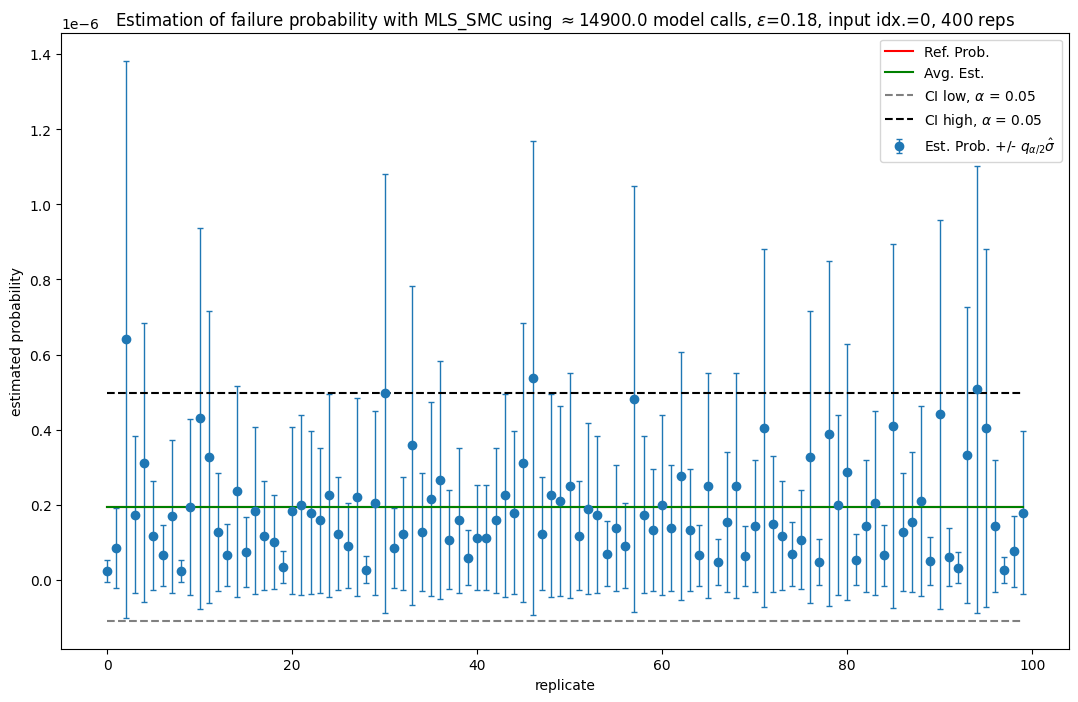

mean est:1.9379353600000009e-07, std est:1.5431844385354047e-07
mean calls:14900.0
std. re.:4109029.5186665524
std. rel. adj.:61224539828.13163
mean rel. error:0.525062611270226
std rel. error:0.593371621928221
stat performance (per 1k calls):8.841237166730494
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 11/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 20: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 12/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [02:45<00:00,  2.41it/s]


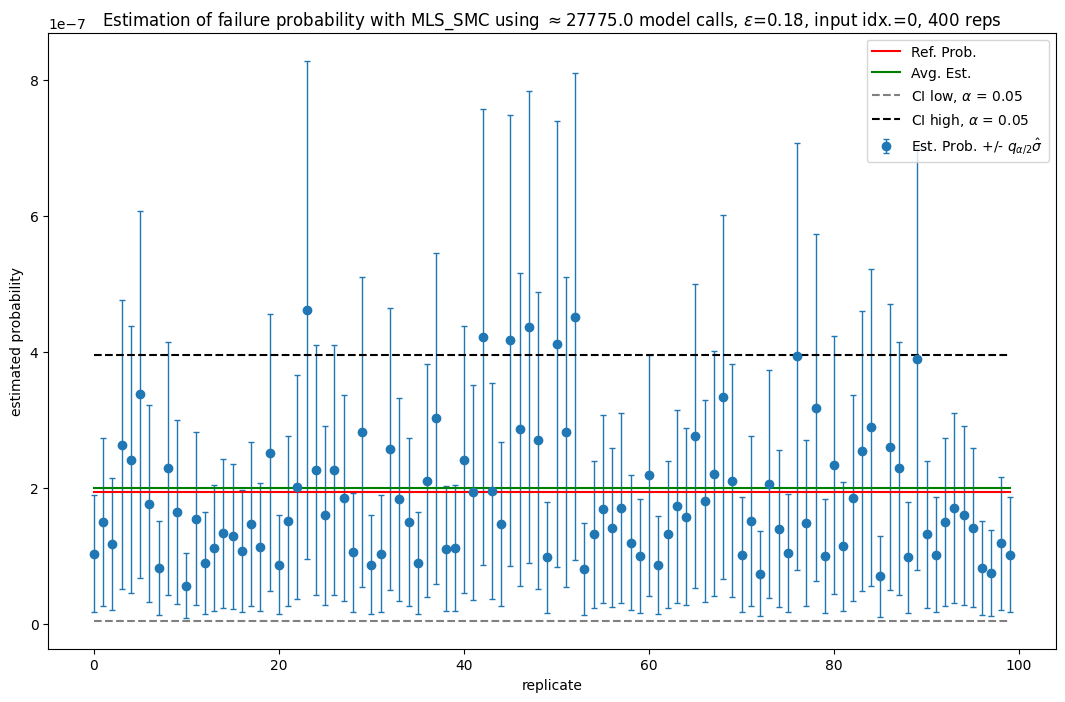

mean est:2.004998278246306e-07, std est:9.981649596328191e-08
mean calls:27775.0
std. re.:2482986.23501959
std. rel. adj.:68964942677.66911
mean rel. error:0.3995672445535278
std rel. error:0.32225851548204204
stat performance (per 1k calls):8.950730267513718
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 13/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.2: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 14/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 15/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.8: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 16/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.2: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 17/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.5: s:

100%|██████████| 400/400 [00:28<00:00, 14.14it/s]


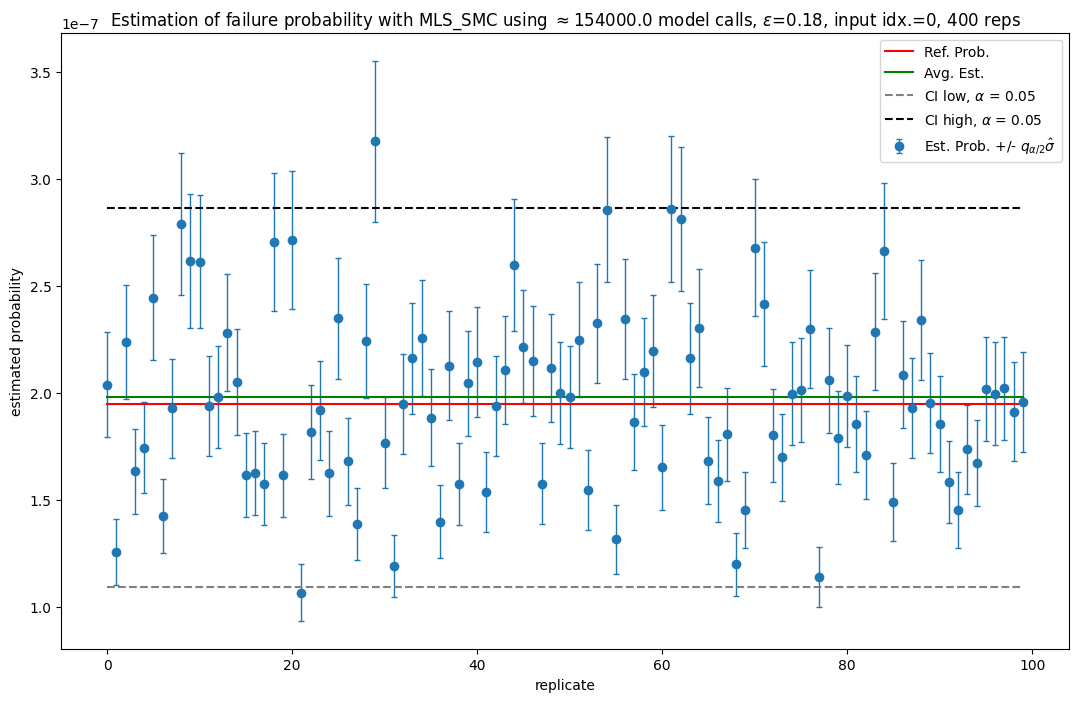

mean est:1.979388160000001e-07, std est:4.514393593140662e-08
mean calls:154000.0
std. re.:1152225.505896107
std. rel. adj.:177442727908.0005
mean rel. error:0.18283861904944043
std rel. error:0.14337672351169609
stat performance (per 1k calls):22.080015420801196
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 26/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 27/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:45<00:00,  8.89it/s]


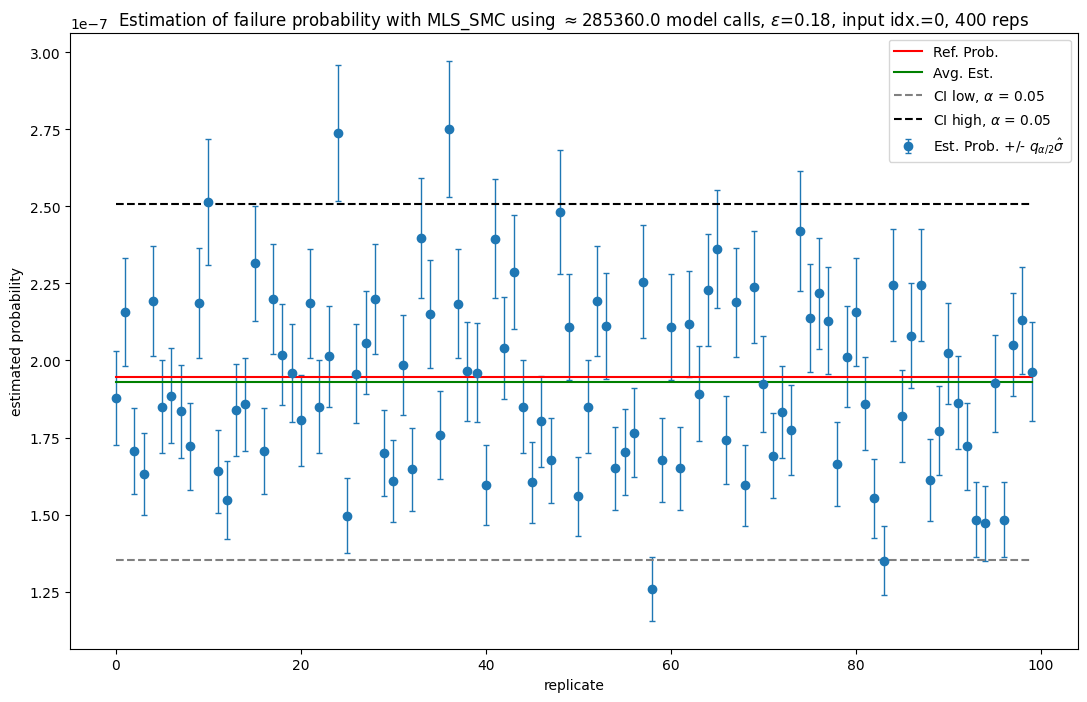

mean est:1.9296330707591091e-07, std est:2.9496031735126003e-08
mean calls:285360.0
std. re.:792162.2173306997
std. rel. adj.:226051410337.48846
mean rel. error:0.12354614923508278
std rel. error:0.08807117982527976
stat performance (per 1k calls):25.131991874941832
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 28/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:02<00:00,  6.38it/s]


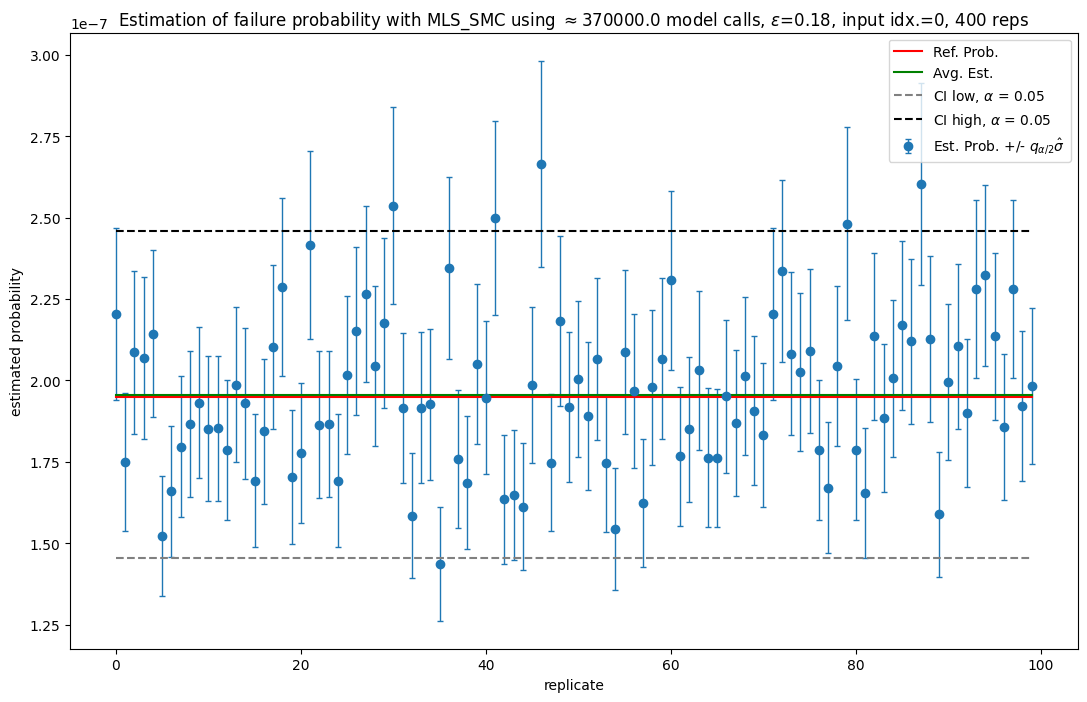

mean est:1.956034560000001e-07, std est:2.5601730276246266e-08
mean calls:370000.0
std. re.:669138.8878706456
std. rel. adj.:247581388512.1389
mean rel. error:0.1042850428023852
std rel. error:0.08013071454716611
stat performance (per 1k calls):29.64836438245146
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 29/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 5: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 30/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:21<00:00,  4.89it/s]


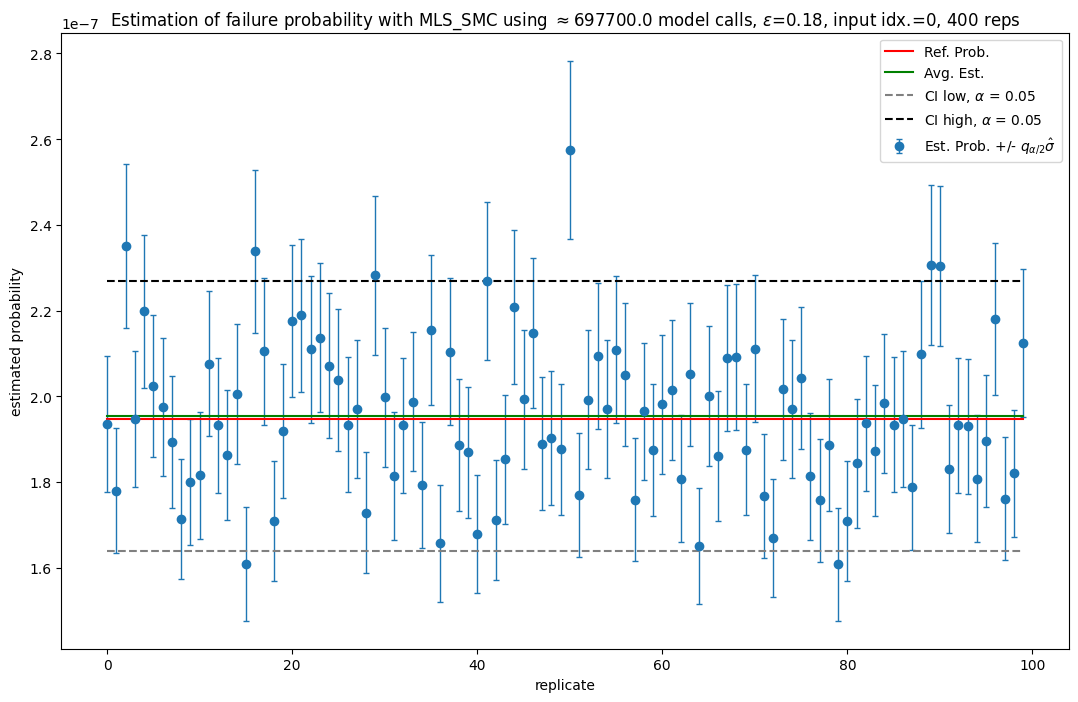

mean est:1.9546001442857874e-07, std est:1.604172842623676e-08
mean calls:697700.0
std. re.:419889.78256965044
std. rel. adj.:292957101298.8451
mean rel. error:0.06407776132248787
std rel. error:0.05186651109623795
stat performance (per 1k calls):36.18726479184522
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 31/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:59<00:00,  3.35it/s]


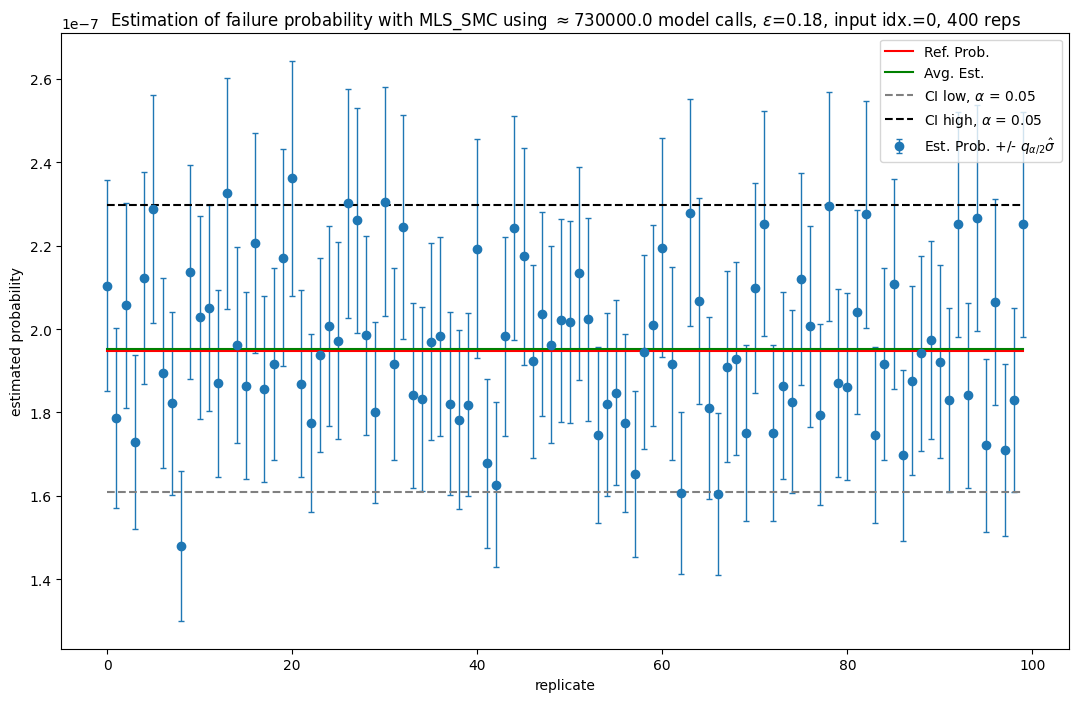

mean est:1.952828160000001e-07, std est:1.7584000170511382e-08
mean calls:730000.0
std. re.:461094.1595181243
std. rel. adj.:336598736448.2307
mean rel. error:0.07208558529043715
std rel. error:0.054416965475629
stat performance (per 1k calls):39.72438479720917
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 32/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 10: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 33/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [02:22<00:00,  2.80it/s]


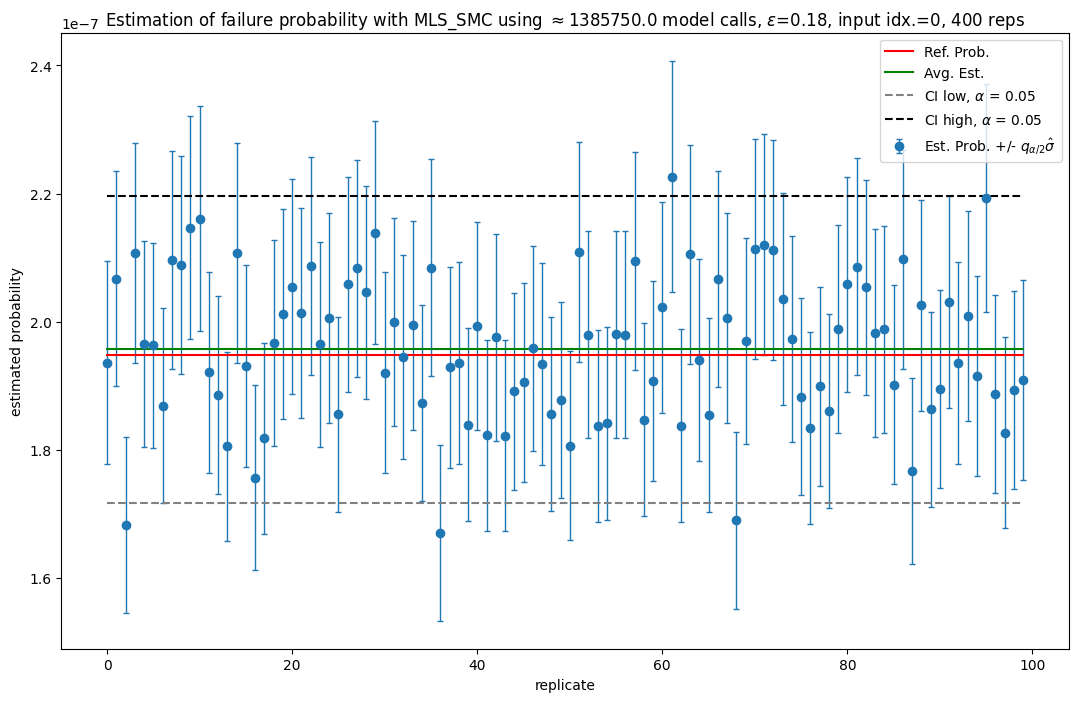

mean est:1.9570929294240766e-07, std est:1.2232515776016742e-08
mean calls:1385750.0
std. re.:319369.09577236534
std. rel. adj.:442565724466.5553
mean rel. error:0.05082101551076172
std rel. error:0.03721450987501363
stat performance (per 1k calls):51.57000705930014
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 34/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [03:53<00:00,  1.72it/s]


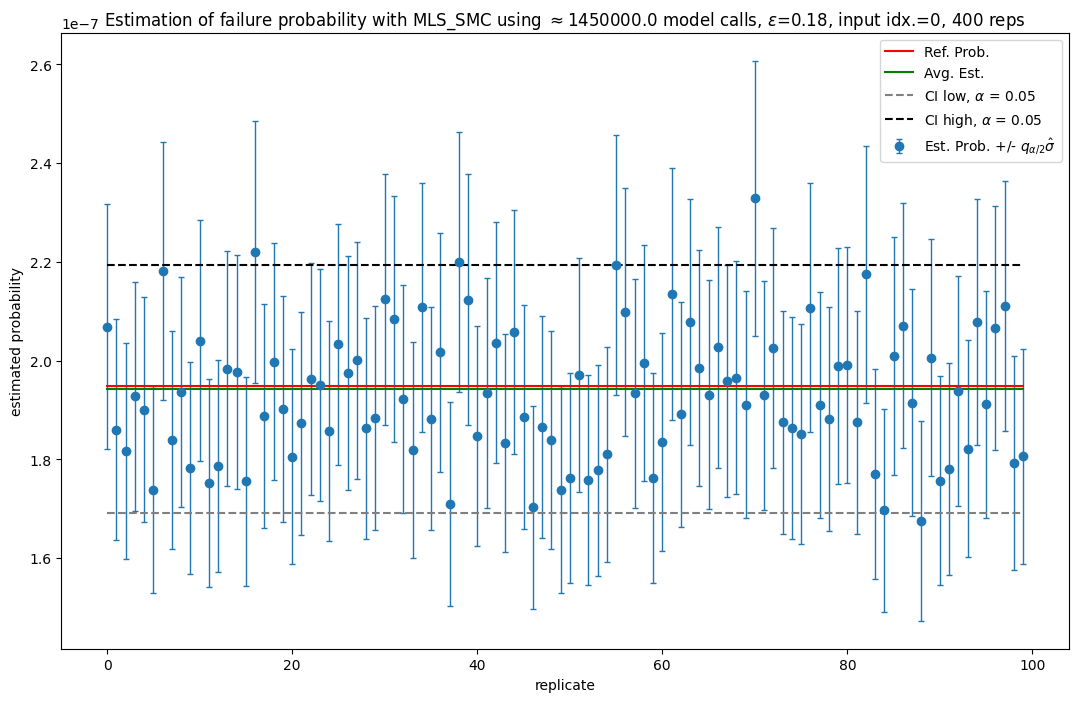

mean est:1.9425139200000008e-07, std est:1.2787616588369242e-08
mean calls:1450000.0
std. re.:338892.0079737974
std. rel. adj.:491393411562.0062
mean rel. error:0.053466509459281275
std rel. error:0.03819675438588315
stat performance (per 1k calls):55.38529385953057
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 35/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 20: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 36/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [04:23<00:00,  1.52it/s]


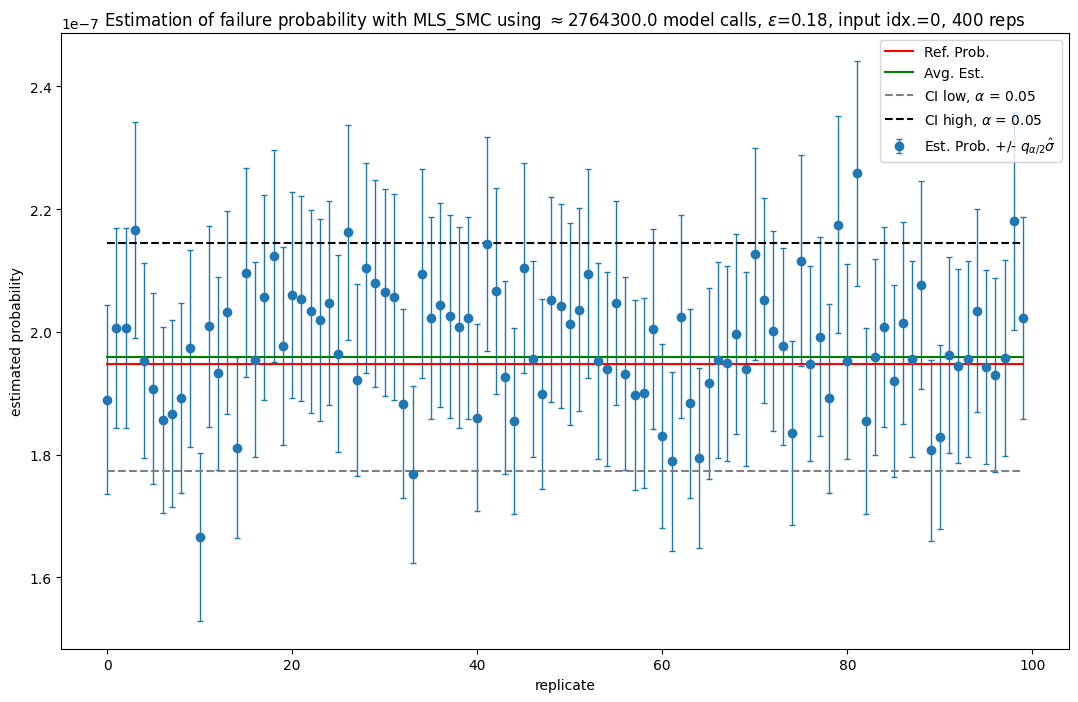

mean est:1.9588075965948228e-07, std est:9.473357237264925e-09
mean calls:2764300.0
std. re.:246899.582459781
std. rel. adj.:682504515793.5726
mean rel. error:0.03863108353541863
std rel. error:0.030097600714562123
stat performance (per 1k calls):83.19879765526409
p_fail_mls: 2.0176766465951106e-07


In [18]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=400, update_aggr_res=True, 
                         N_range=[100,100,10000, 
                                  ],T_range=[2,5,10,20],ratio_range=[0.2,0.5,0.8,],repeat_exp=False,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.7,0.8],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[3000],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[3000], [20], [0.7, 0.8], [0.2], [1]]
{'N_range': [3000], 'T_range': [20], 'ess_alpha_range': [0.7, 0.8], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.7: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


mean est:7.125619845282927e-07, std est:0.0
mean calls:1806200.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 2/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


mean est:1.429374947292672e-06, std est:0.0
mean calls:1792200.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=1.0709684659104823e-06


with parameters in {'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


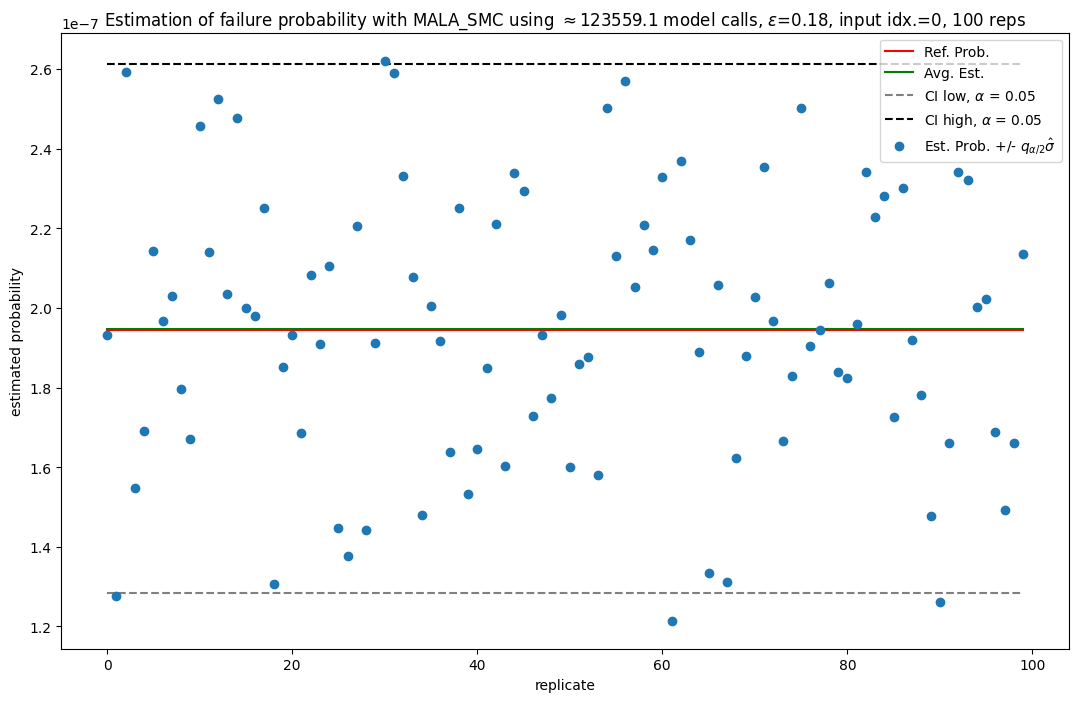

mean est:1.947763398391089e-07, std est:3.3910787382815905e-08
mean calls:123559.1
std. re.:893851.7050677764
std. rel. adj.:110443512211.6399
mean rel. error:0.14067106655076209
std rel. error:0.10307205941389559
stat performance (per 1k calls):12.735490896327468
p_fail_mala=1.947763398391089e-07


In [83]:
p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

In [ ]:
exp_config.model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [14]:
model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [50]:
1125858/5e7

0.02251716

In [51]:
p_fail_form,dict_out_form = run_exp.run_stat_rel_exp(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

[[1000], [10], [0.01]]
{'steps_range': [1000], 'num_iter_range': [10], 'stepsize_range': [0.01]}
Starting FORM simulation 1/1, with model: mnist_model, img_idx:0,eps:0.2,steps: 1000: num_iter: 10: stepsize: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:19<00:00, 19.32s/it]


mean est:2.9287436643461935e-10, std est:0.0
mean calls:10000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.9999991309993812
std rel. error:0.0
stat performance (per 1k calls):0.0


In [78]:
p_fail_mc, dict_out_mc = run_exp.run_est(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=5, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

with parameters in {'N_range': [100000000], 'batch_size_range': [400000]}
Starting CrudeMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


 20%|██        | 1/5 [00:34<02:16, 34.19s/it]


KeyboardInterrupt: 

In [53]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [65]:
eps=0.18

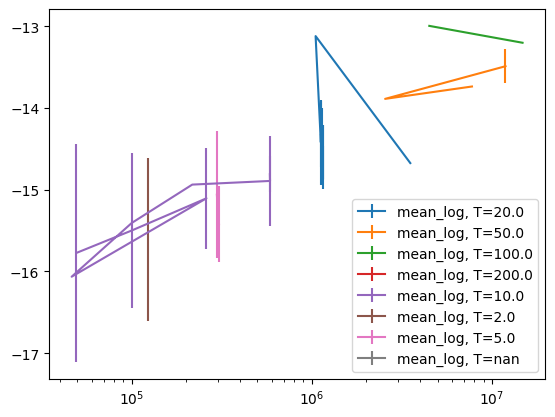

In [68]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

